# Baseline training models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/MyDrive/ICE-human-heatflux-project/

 Baseline_training_utils_2.py	       runs
 lstm_utils.py			       runs_2
 lstm_v1.pth			       Test_final.csv
 __pycache__			       Test_without_FE.csv
'Resultats_LSTM_without_FE (1).gdoc'   Train_final.csv
 Resultats_LSTM_without_FE.gdoc        Train_without_FE.csv


In [3]:
import sys

from sklearn.linear_model import LinearRegression, Lasso, MultiTaskLasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [4]:
BASE_PATH = "/content/drive/MyDrive/ICE-human-heatflux-project"
RUNS_DIR = "/content/drive/MyDrive/ICE-human-heatflux-project/runs"
sys.path.append(BASE_PATH)

from Baseline_training_utils_2 import *

In [5]:
data_training       = pd.read_csv(f"{BASE_PATH}/Train_without_FE.csv")
data_test           = pd.read_csv(f"{BASE_PATH}/Test_without_FE.csv")
data_training_HF = pd.read_csv(f"{BASE_PATH}/Train_final.csv")
data_test_HF     = pd.read_csv(f"{BASE_PATH}/Test_final.csv")


X_train     = data_training.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)
X_test      = data_test.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)
X_train_HF  = data_training_HF.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)
X_test_HF   = data_test_HF.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)

y_train     = data_training[['back_flux', 'thigh_flux']]
y_test      = data_test[['back_flux', 'thigh_flux']]
y_train_HF  = data_training_HF[['back_flux', 'thigh_flux']]
y_test_HF   = data_test_HF[['back_flux', 'thigh_flux']]

X_test_plot = data_test.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)
X_test_HF_plot = data_test_HF.drop(['back_flux','thigh_flux','day','Session','room_temp_C'], axis=1)

X_train.head()

participant_id                 Time  chair_back_flux  chair_thigh_flux  \
0             F1  2023-02-17 08:46:20        -0.115799         -0.071529   
1             F1  2023-02-17 08:46:21        -0.111278         -0.076312   
2             F1  2023-02-17 08:46:22        -0.107046         -0.080694   
3             F1  2023-02-17 08:46:23        -0.103098         -0.084694   
4             F1  2023-02-17 08:46:24        -0.099427         -0.088331   

   Sensor 0  Sensor 1  Sensor 2  Sensor 3  Sensor 4  Sensor 5      Sensor 6  \
0  0.000052       0.0       0.0       0.0       0.0       0.0 -1.809101e-05   
1  0.000034       0.0       0.0       0.0       0.0       0.0 -1.289537e-05   
2  0.000019       0.0       0.0       0.0       0.0       0.0 -8.124421e-06   
3  0.000006       0.0       0.0       0.0       0.0       0.0 -3.763936e-06   
4 -0.000005       0.0       0.0       0.0       0.0       0.0  2.003212e-07   

   Sensor 7  Sensor 9  Sensor 10  Sensor 11  Sensor 12  
0       0.0  0.004174        0.0        0.0        0.0  
1       0.0  0.004170        0.0        0.0        0.0  
2       0.0  0.004167        0.0        0.0        0.0  
3       0.0  0.004163        0.0        0.0        0.0  
4       0.0  0.004159        0.0        0.0        0.0

## Task 1: Baseline multi-outputs models without historical features  

Baseline models are trained to simultaneously predict thigh_flux and back_flux, using a fixed output order across the pipeline. They are selected by choosing a model name, which automatically loads the corresponding estimator:
- **Linear Regression**: $\hat{y} = X\beta$
- **Lasso Regression**: $\hat{y} = X\beta$ with an $\ell_1$ penalty on $\beta$
- **Random Forest**: combines multiple decision trees, $\hat{y} = \frac{1}{T}\sum_{t=1}^T f_t(X)$.

Models with meaningful hyperparameters (Lasso, Random Forest) are tuned using GridSearchCV with 5-fold cross-validation.

Performance is evaluated using the Mean Absolute Error (MAE):  
$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} \lvert y_i - \hat{y}_i \rvert$.



## 1.A Linear Regression: Plots

In [6]:
linear_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

bundle_lr_mo = cv_select_and_refit_on_full_train_multioutput(
    X_train=X_train,
    y_train=y_train,
    base_estimator=linear_pipe,
    param_grid={},
    model_name="Linear_MO",
    model_title="LR_multi",
    participant_col="participant_id",
    time_col="Time",
    bundle_dir=RUNS_DIR
)

[Linear_MO] #param combinations: 1 | outer folds: 5

[Linear_MO] Combo 1/1: {}
    Fold 1: thigh=16.878 | back=16.453 | mean=16.666
    Fold 2: thigh=13.829 | back=14.479 | mean=14.154
    Fold 3: thigh=13.051 | back=19.119 | mean=16.085
    Fold 4: thigh=15.942 | back=13.613 | mean=14.778
    Fold 5: thigh=11.365 | back=15.311 | mean=13.338
    → MEAN ± STD | thigh: 14.213 ± 1.985 | back: 15.795 ± 1.908 | mean: 15.004 ± 1.223

[Linear_MO] BEST params by mean(2 outputs) outer MAE = 15.0041
  best_params: {}
  thigh MAE: 14.2132 | back MAE: 15.7950

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_multi.joblib


In [7]:
# bundle_lr_mo = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_multi.joblib')

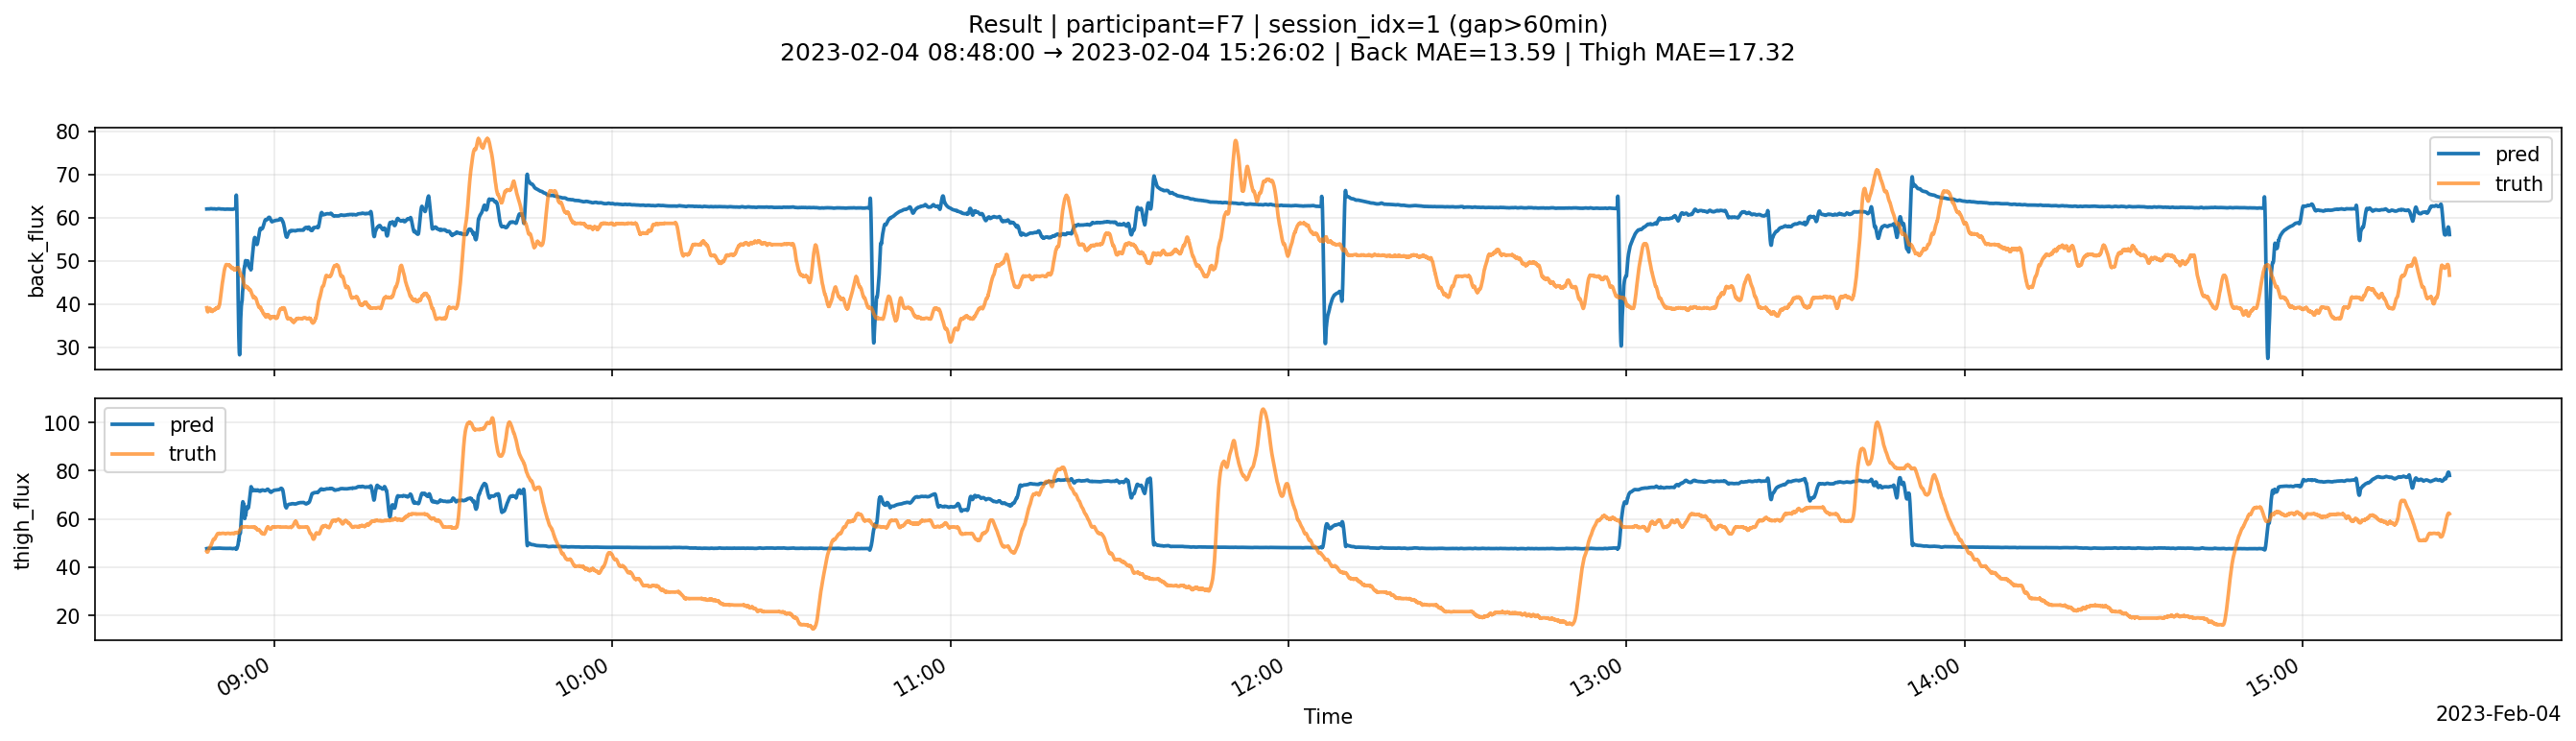

In [8]:
out_lr, mae_lr_thigh, mae_lr_back = plot_and_predict_multioutput_by_gap_session(
    bundle=bundle_lr_mo,
    X_df=X_test,
    y_df=y_test,
    participant_id="F7",
    session_idx=1,
    gap_minutes=60,
    participant_col="participant_id",
    time_col="Time",
    target_cols=("back_flux", "thigh_flux"),
    drop_cols_for_X=["participant_id", "Time"],
    drop_non_numeric=True
)

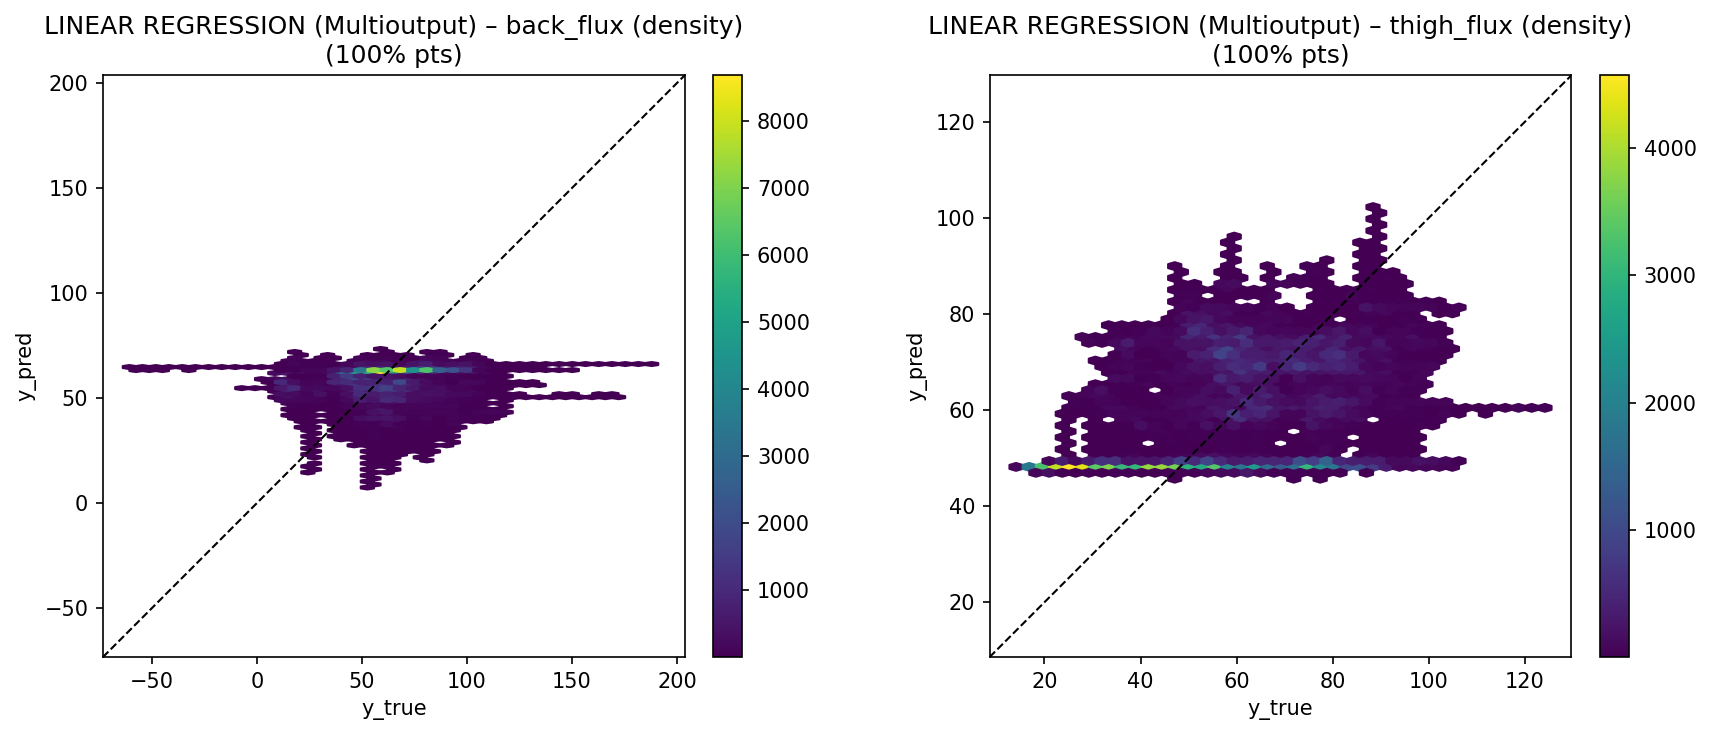

In [9]:
X_test_num = (
    X_test
      .drop(columns=["participant_id", "Time"], errors="ignore")
      .select_dtypes(include=["number", "bool"])
)

preds_lr_mo_test = bundle_lr_mo["model"].predict(X_test_num)
preds_lr_mo_test = np.asarray(preds_lr_mo_test, dtype=float)
y_true_lr_mo_test = y_test[["back_flux", "thigh_flux"]].to_numpy()

plot_true_vs_pred_density_multioutput(
    y_true=y_true_lr_mo_test,
    y_pred=preds_lr_mo_test,
    model_name="LINEAR REGRESSION (Multioutput)",
    pct=100,
    target_names=("back_flux", "thigh_flux")
)

## 1.B Lasso Regression: Grid search and plots

In [10]:
mtl_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mtlasso", MultiTaskLasso(max_iter=10_000))
])

mtl_grid = {"mtlasso__alpha": [0.75, 0.8, 0.85, 0.9, 0.95]}

bundle_lasso_mo = cv_select_and_refit_on_full_train_multioutput(
    X_train=X_train,
    y_train=y_train,
    base_estimator=mtl_pipe,
    param_grid=mtl_grid,
    model_name="Lasso_MO",
    model_title="LASSO_multi",
    participant_col="participant_id",
    time_col="Time",
    bundle_dir=RUNS_DIR
)

[Lasso_MO] #param combinations: 5 | outer folds: 5

[Lasso_MO] Combo 1/5: {'mtlasso__alpha': 0.75}
    Fold 1: thigh=16.865 | back=15.942 | mean=16.403
    Fold 2: thigh=13.867 | back=14.269 | mean=14.068
    Fold 3: thigh=13.033 | back=18.825 | mean=15.929
    Fold 4: thigh=15.958 | back=13.161 | mean=14.559
    Fold 5: thigh=10.939 | back=15.225 | mean=13.082
    → MEAN ± STD | thigh: 14.132 ± 2.111 | back: 15.484 ± 1.914 | mean: 14.808 ± 1.216

[Lasso_MO] Combo 2/5: {'mtlasso__alpha': 0.8}
    Fold 1: thigh=16.857 | back=15.943 | mean=16.400
    Fold 2: thigh=13.870 | back=14.277 | mean=14.073
    Fold 3: thigh=13.027 | back=18.831 | mean=15.929
    Fold 4: thigh=15.953 | back=13.145 | mean=14.549
    Fold 5: thigh=10.931 | back=15.238 | mean=13.084
    → MEAN ± STD | thigh: 14.128 ± 2.111 | back: 15.487 ± 1.919 | mean: 14.807 ± 1.214

[Lasso_MO] Combo 3/5: {'mtlasso__alpha': 0.85}
    Fold 1: thigh=16.849 | back=15.948 | mean=16.399
    Fold 2: thigh=13.873 | back=14.285 | mean=14.

In [11]:
# bundle_lasso_mo = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_multi.joblib')

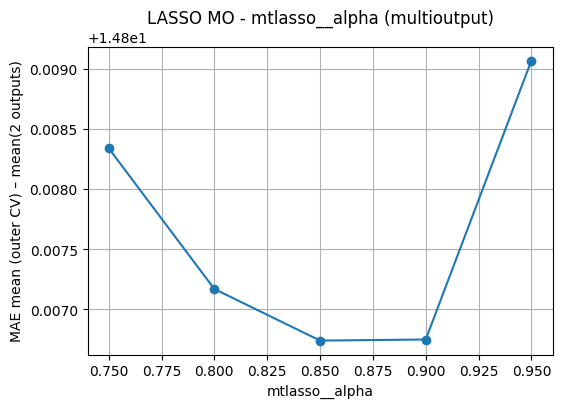

In [12]:
plot_grid_search_results_multioutput(
    bundle_lasso_mo["summary_df"],
    param_name="mtlasso__alpha",
    model_name="LASSO MO"
)
plt.show()

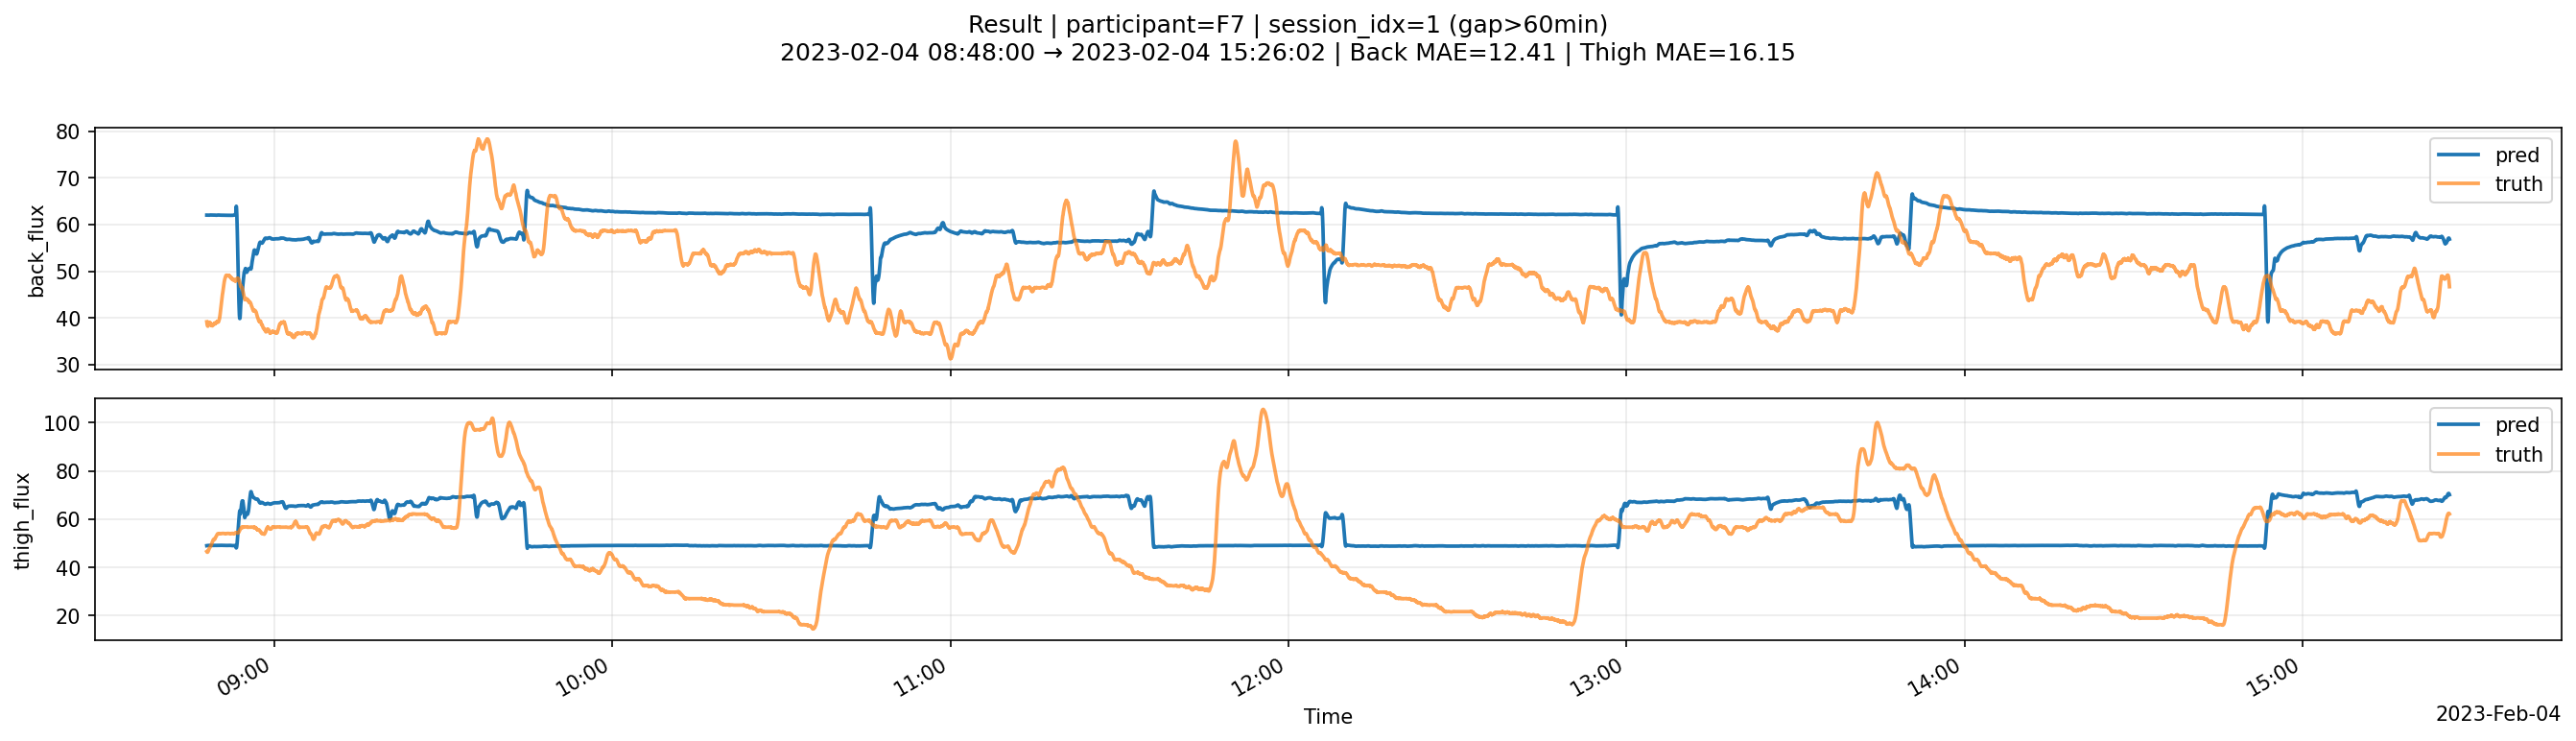

In [13]:
out_lasso, mae_lasso_thigh, mae_lasso_back = plot_and_predict_multioutput_by_gap_session(
    bundle=bundle_lasso_mo,
    X_df=X_test,
    y_df=y_test,
    participant_id="F7",
    session_idx=1,
    gap_minutes=60,
    participant_col="participant_id",
    time_col="Time",
    target_cols=("back_flux", "thigh_flux"),
    drop_cols_for_X=["participant_id", "Time"],
    drop_non_numeric=True
)

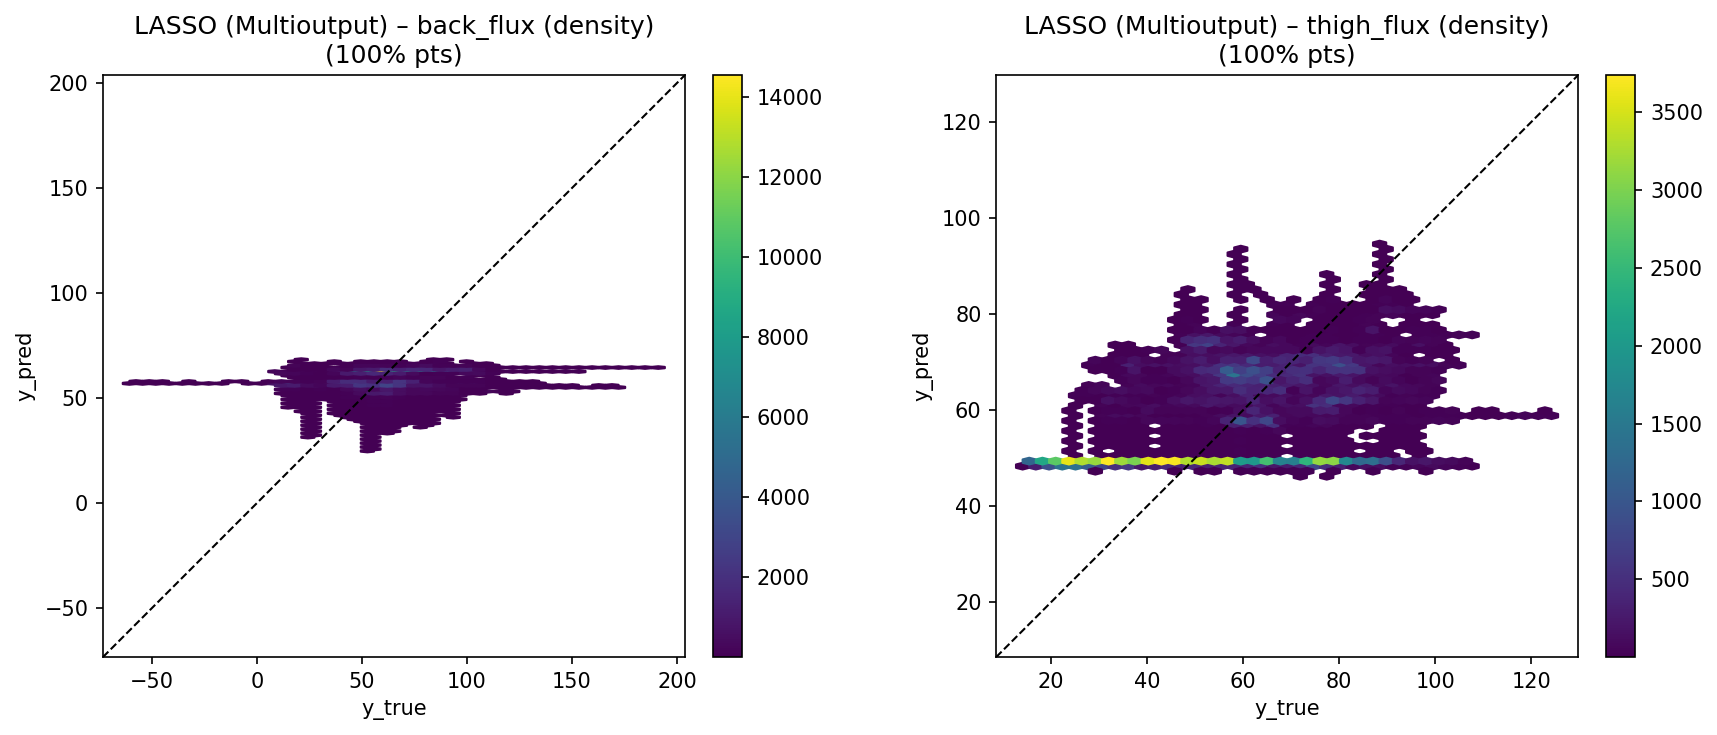

In [14]:
X_test_num = (
    X_test
      .drop(columns=["participant_id", "Time"], errors="ignore")
      .select_dtypes(include=["number", "bool"])
)

preds_lasso_mo_test = bundle_lasso_mo["model"].predict(X_test_num)
preds_lasso_mo_test = np.asarray(preds_lasso_mo_test, dtype=float)
y_true_lasso_mo_test = y_test[["back_flux", "thigh_flux"]].to_numpy()

plot_true_vs_pred_density_multioutput(
    y_true=y_true_lasso_mo_test,
    y_pred=preds_lasso_mo_test,
    model_name="LASSO (Multioutput)",
    pct=100,
    target_names=("back_flux", "thigh_flux")
)

## 1.C Ridge Regression: Grid search and plots

In [15]:
mt_ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())   # multi-output natif
])

mt_ridge_grid = {
    "ridge__alpha": [10.0, 100.0, 150.0, 200.0, 250.0, 300.0, 1000.0, 5000.0, 10000.0, 20000.0, 50000.0, 100000.0, 500000.0]
}

bundle_ridge_mo = cv_select_and_refit_on_full_train_multioutput(
    X_train=X_train,
    y_train=y_train,
    base_estimator=mt_ridge_pipe,
    param_grid=mt_ridge_grid,
    model_name="Ridge_MO",
    model_title="RIDGE_multi",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    drop_non_numeric=True,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[Ridge_MO] #param combinations: 13 | outer folds: 5

[Ridge_MO] Combo 1/13: {'ridge__alpha': 10.0}
    Fold 1: thigh=16.879 | back=16.453 | mean=16.666
    Fold 2: thigh=13.829 | back=14.479 | mean=14.154
    Fold 3: thigh=13.051 | back=19.119 | mean=16.085
    Fold 4: thigh=15.942 | back=13.613 | mean=14.778
    Fold 5: thigh=11.365 | back=15.311 | mean=13.338
    → MEAN ± STD | thigh: 14.213 ± 1.985 | back: 15.795 ± 1.909 | mean: 15.004 ± 1.223

[Ridge_MO] Combo 2/13: {'ridge__alpha': 100.0}
    Fold 1: thigh=16.879 | back=16.452 | mean=16.665
    Fold 2: thigh=13.829 | back=14.477 | mean=14.153
    Fold 3: thigh=13.051 | back=19.118 | mean=16.085
    Fold 4: thigh=15.943 | back=13.610 | mean=14.777
    Fold 5: thigh=11.363 | back=15.311 | mean=13.337
    → MEAN ± STD | thigh: 14.213 ± 1.986 | back: 15.794 ± 1.909 | mean: 15.003 ± 1.223

[Ridge_MO] Combo 3/13: {'ridge__alpha': 150.0}
    Fold 1: thigh=16.879 | back=16.451 | mean=16.665
    Fold 2: thigh=13.829 | back=14.477 | mean=14

In [16]:
# bundle_ridge_mo = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RIDGE_multi.joblib')

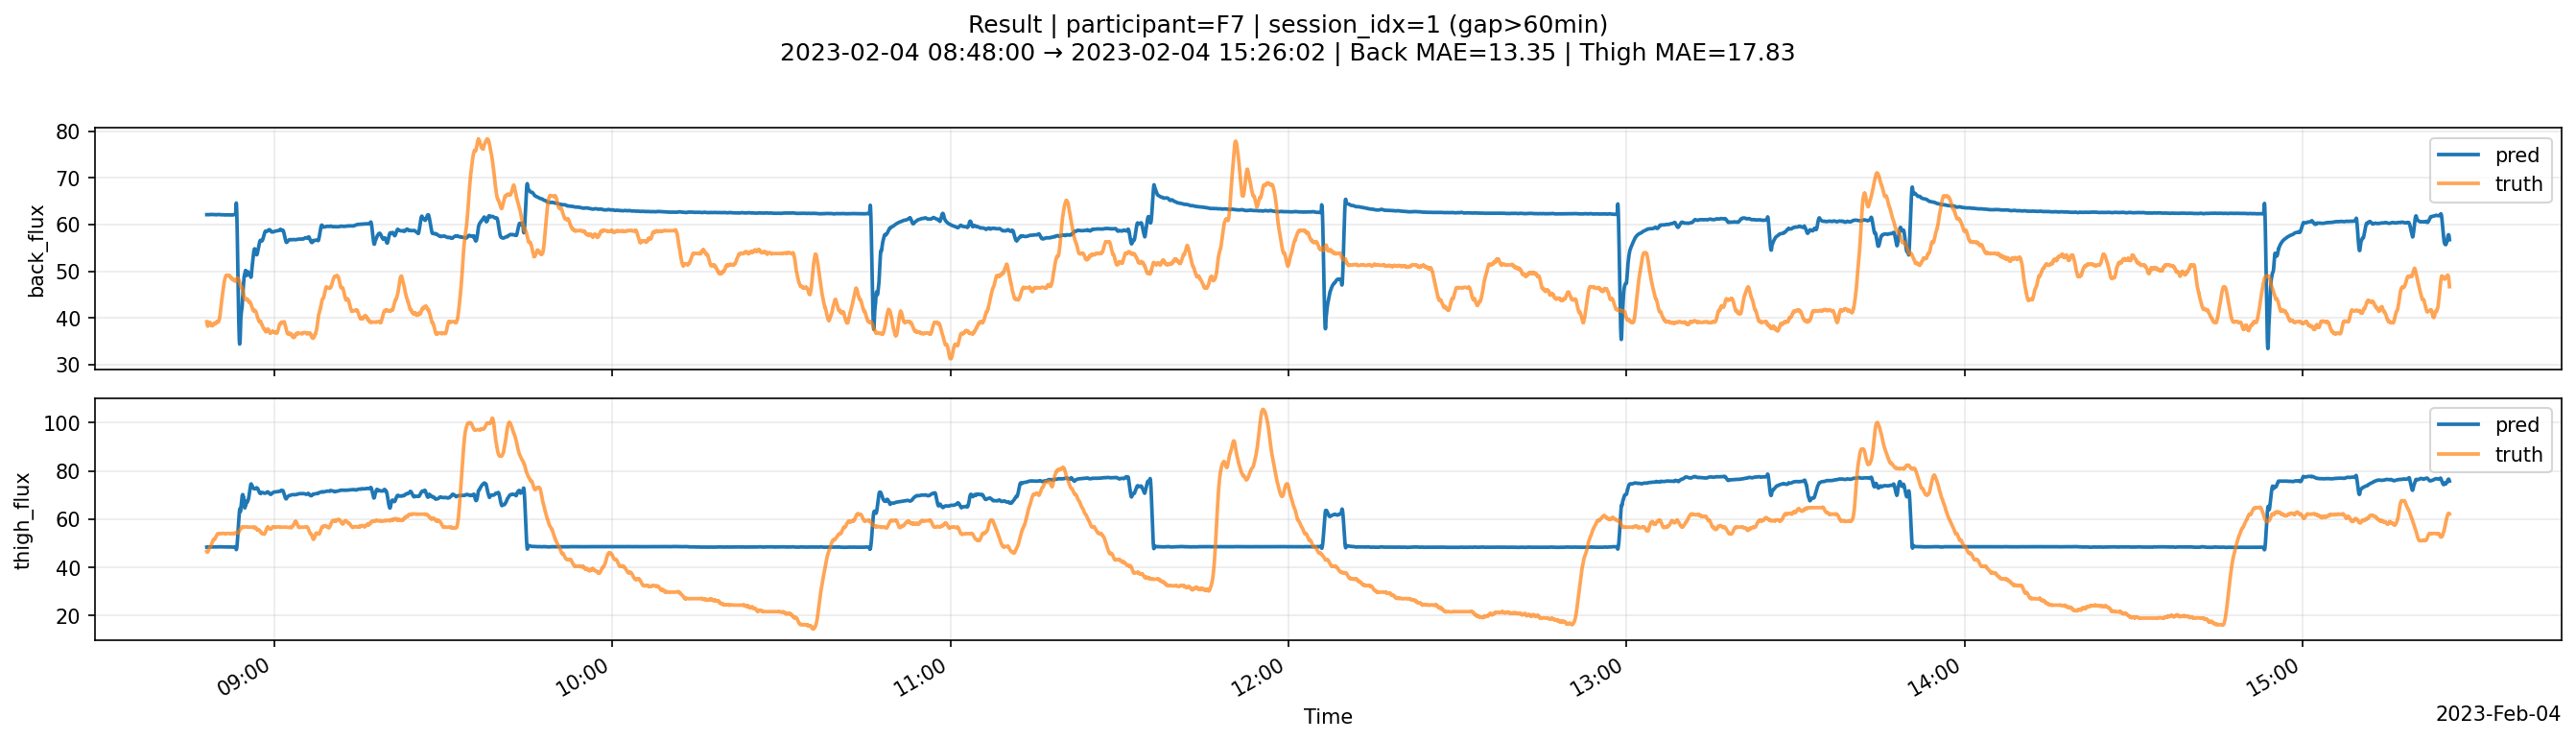

In [17]:
out_ridge, mae_ridge_thigh, mae_ridge_back = plot_and_predict_multioutput_by_gap_session(
    bundle=bundle_ridge_mo,
    X_df=X_test,
    y_df=y_test,
    participant_id="F7",
    session_idx=1,
    gap_minutes=60,
    participant_col="participant_id",
    time_col="Time",
    target_cols=("back_flux", "thigh_flux"),
    drop_cols_for_X=["participant_id", "Time"],
    drop_non_numeric=True
)

## 1.D Random Forest: Grid search and plots

In [18]:
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# rf_grid = {
    # "n_estimators": [200, 400],
    # "max_depth": [8, 12],
    # "min_samples_split": [5, 10],
# }

# bundle_rf_mo = cv_select_and_refit_on_full_train_multioutput(
    # X_train=X_train,
    # y_train=y_train,
    # base_estimator=rf,
    # param_grid=rf_grid,
    # model_name="RF_MO",
    # model_title="RF_multi",
    # participant_col="participant_id",
    # time_col="Time",
    # bundle_dir=RUNS_DIR
# )

In [19]:
bundle_rf_mo = joblib.load("/content/drive/MyDrive/ICE-human-heatflux-project/runs/RF_multi.joblib")

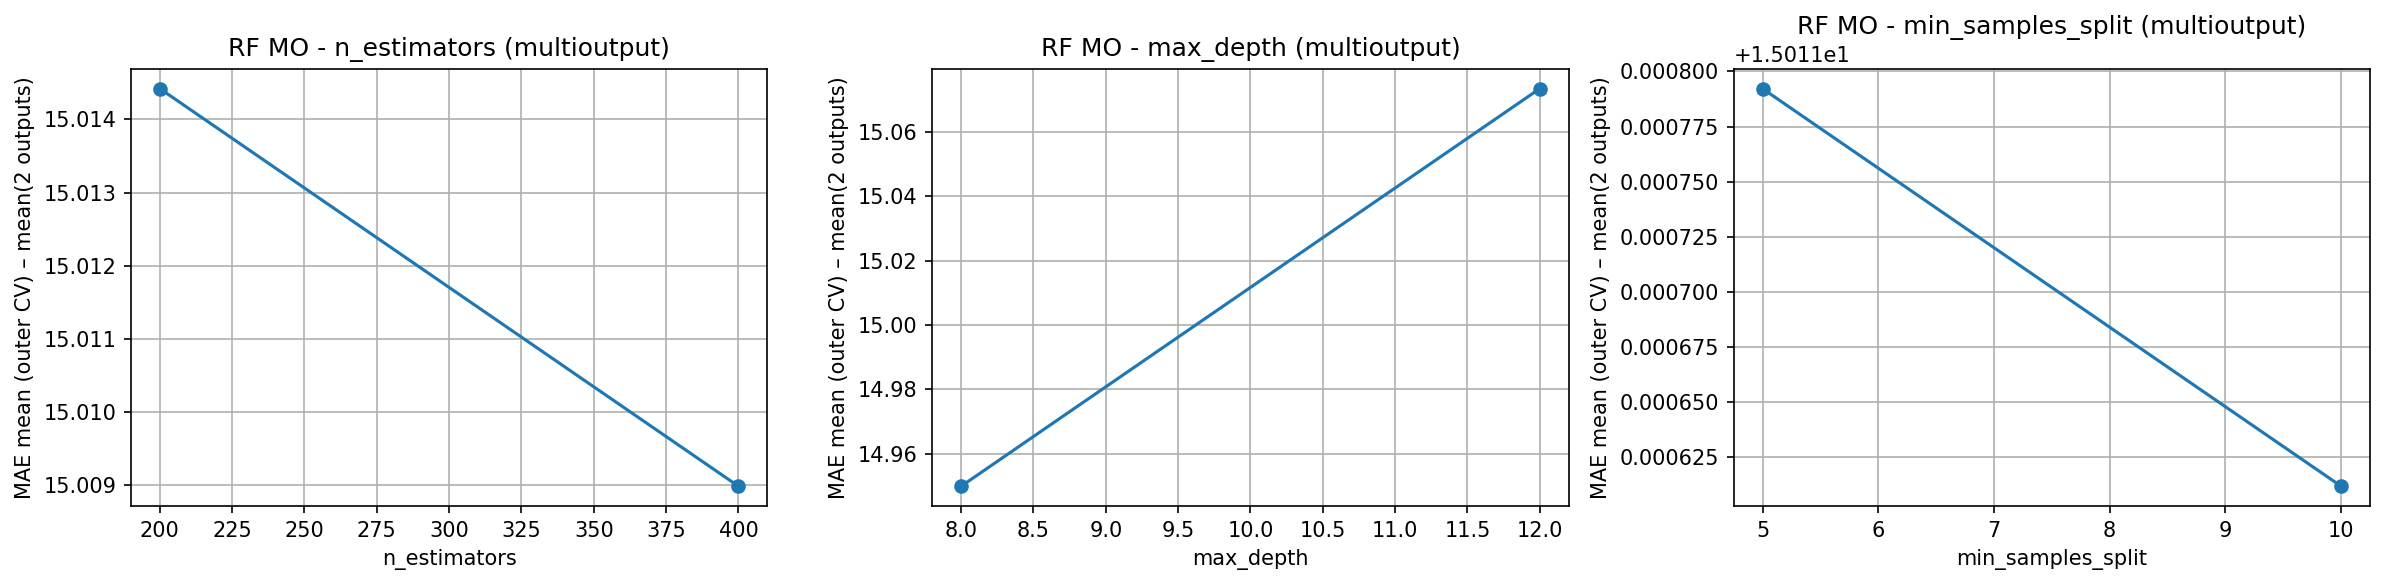

In [20]:
plot_rf_grid_search_multioutput(
    bundle_rf_mo["summary_df"],
    model_name="RF MO"
)

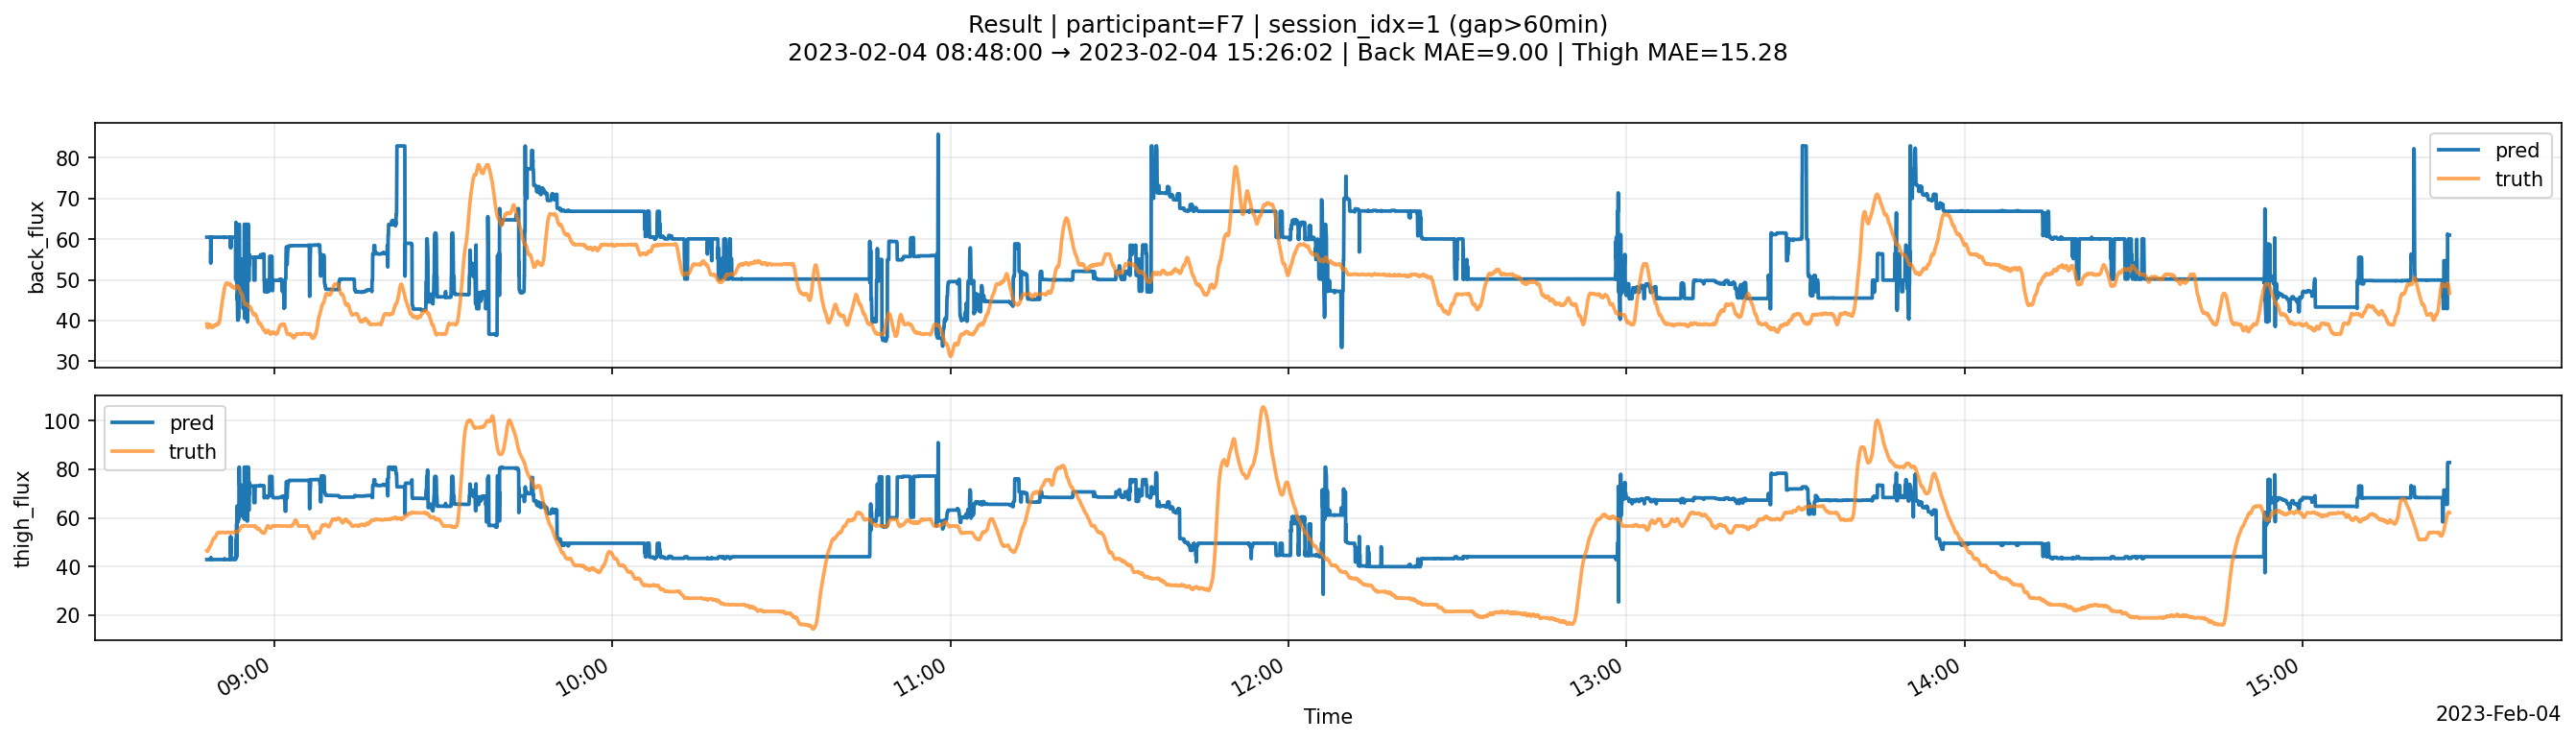

In [21]:
out_rf, mae_rf_thigh, mae_rf_back = plot_and_predict_multioutput_by_gap_session(
    bundle=bundle_rf_mo,
    X_df=X_test,
    y_df=y_test,
    participant_id="F7",
    session_idx=1,
    gap_minutes=60,
    participant_col="participant_id",
    time_col="Time",
    target_cols=("back_flux", "thigh_flux"),
    drop_cols_for_X=["participant_id", "Time"],
    drop_non_numeric=True
)

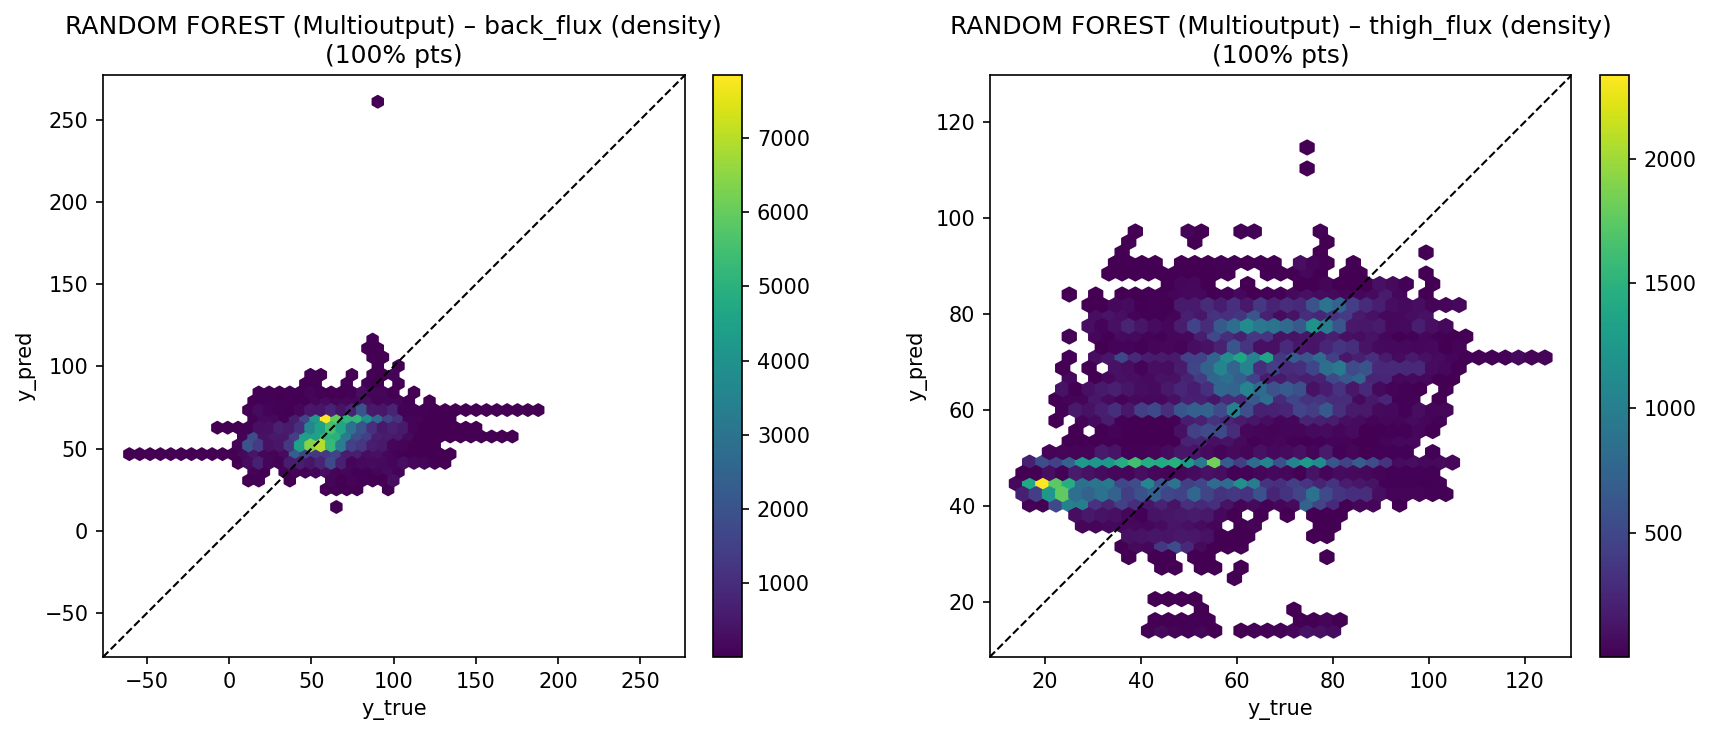

In [22]:
X_test_num = (
    X_test
      .drop(columns=["participant_id", "Time"], errors="ignore")
      .select_dtypes(include=["number", "bool"])
)

preds_rf_mo_test = bundle_rf_mo["model"].predict(X_test_num)
preds_rf_mo_test = np.asarray(preds_rf_mo_test, dtype=float)
y_true_rf_mo_test = y_test[["back_flux", "thigh_flux"]].to_numpy()

plot_true_vs_pred_density_multioutput(
    y_true=y_true_rf_mo_test,
    y_pred=preds_rf_mo_test,
    model_name="RANDOM FOREST (Multioutput)",
    pct=100,
    target_names=("back_flux", "thigh_flux")
)

## Task 2: Baseline single-output models without historical engeeniring

Baseline models are trained to predict a single target variable at a time (either thigh_flux or back_flux), with independent models fitted for each output. The same models as in the single-output setting are used to allow a fair comparison between both approaches.

Models with meaningful hyperparameters (Lasso, Random Forest) are tuned using GridSearchCV with 5-fold cross-validation.

Performance is evaluated using the Mean Absolute Error (MAE):  
$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} \lvert y_i - \hat{y}_i \rvert$.



### 2.A Linear Regression: Plots

In [23]:
bundle_linear_back = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["back_flux"]],
    base_estimator=linear_pipe,
    param_grid={},
    model_name="linear_regression",
    model_title="LR_back_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[linear_regression] #param combinations: 1 | outer folds: 5
  Combo 1/1: {}
    MAE mean/std over folds: 14.2132 ± 1.9852

[linear_regression] BEST params = {}
[linear_regression] BEST MAE = 14.2132

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_back_flux.joblib


In [24]:
bundle_linear_thigh = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["thigh_flux"]],
    base_estimator=linear_pipe,
    param_grid={},
    model_name="linear_regression",
    model_title="LR_thigh_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[linear_regression] #param combinations: 1 | outer folds: 5
  Combo 1/1: {}
    MAE mean/std over folds: 15.7950 ± 1.9085

[linear_regression] BEST params = {}
[linear_regression] BEST MAE = 15.7950

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_thigh_flux.joblib


In [25]:
# bundle_linear_back = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_back_flux.joblib')
# bundle_linear_thigh = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_thigh_flux.joblib')

In [26]:
model_linear_back  = bundle_linear_back["model"]
model_linear_thigh = bundle_linear_thigh["model"]

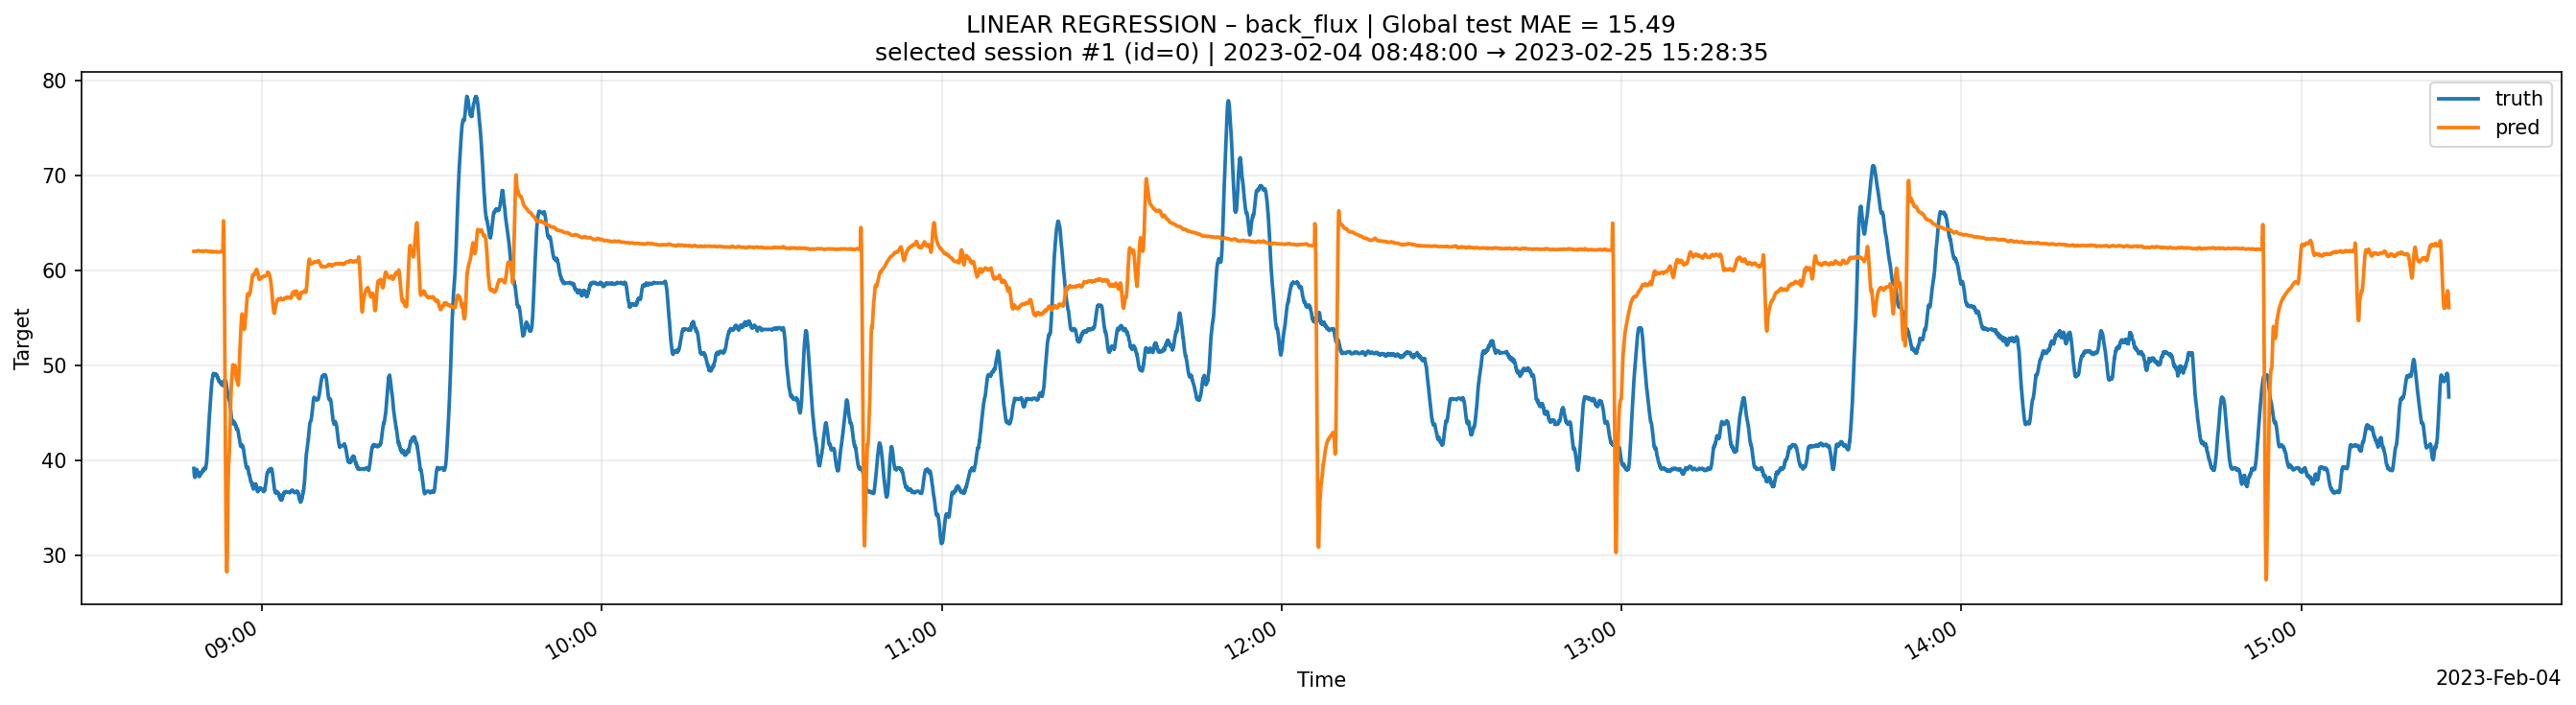

In [27]:
pred_df_back = predict_and_plot(
    model=model_linear_back,
    X_test=X_test,
    y_test=y_test["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LINEAR REGRESSION – back_flux"
)

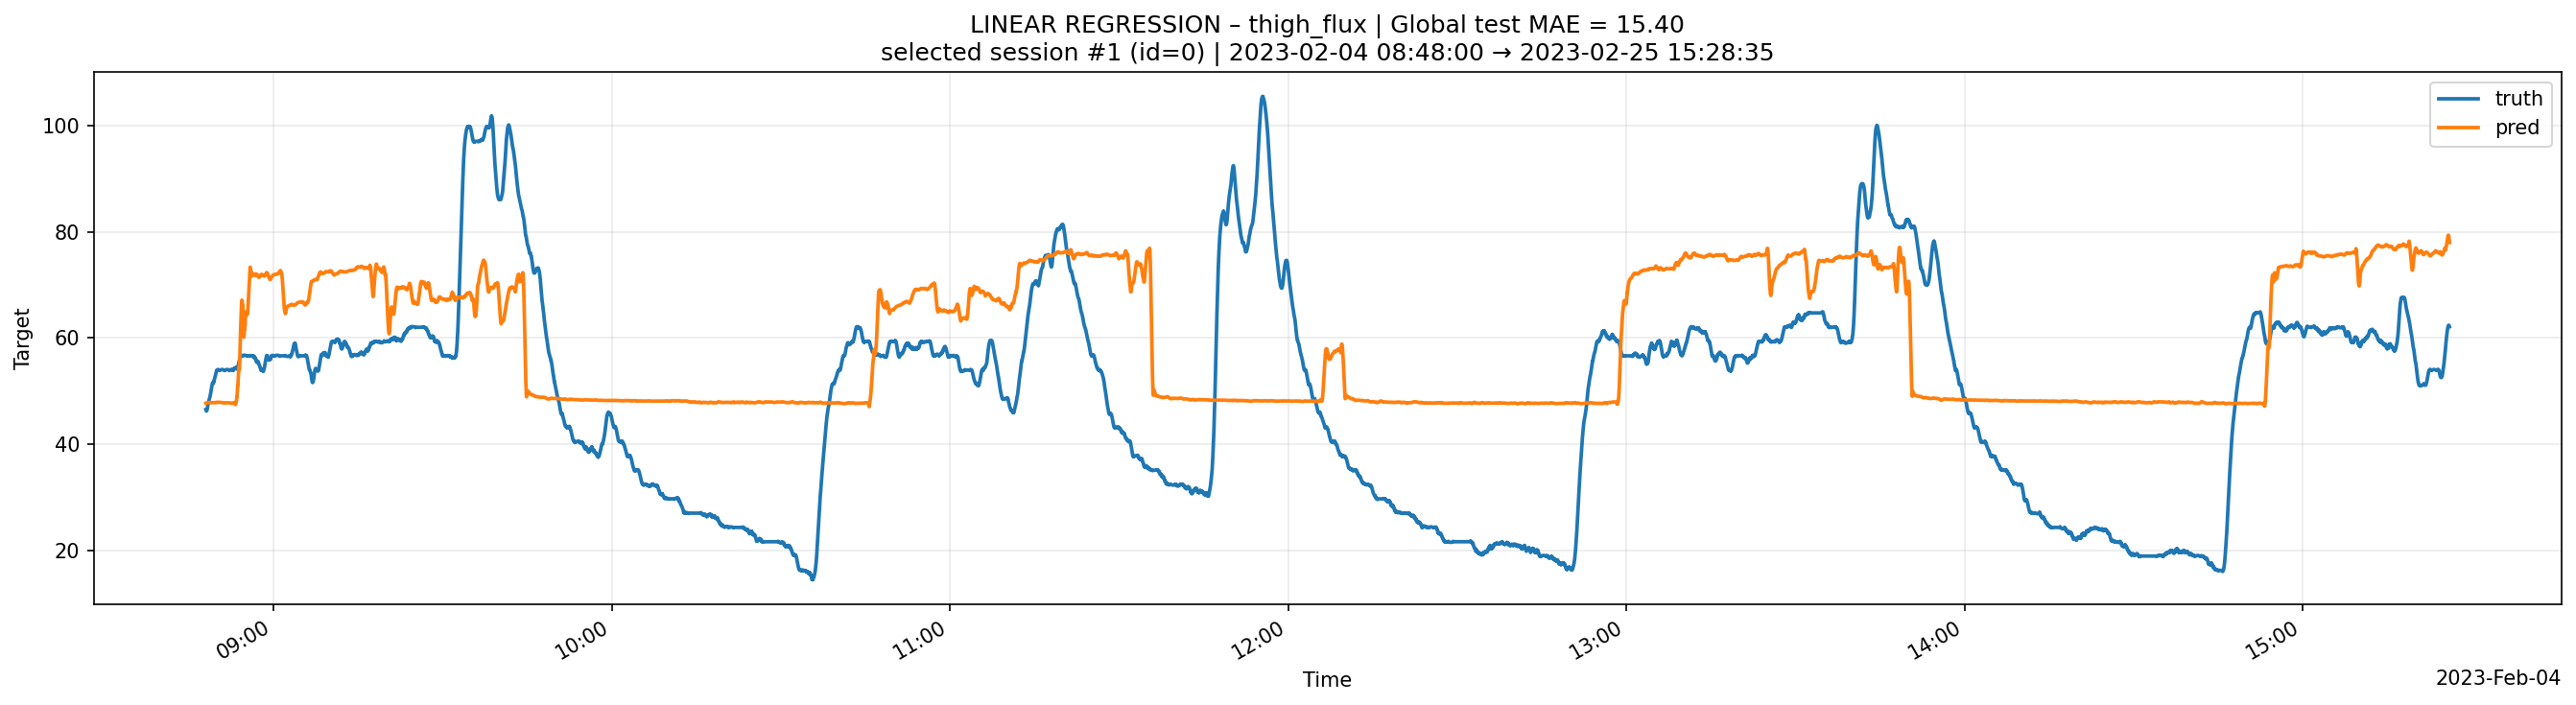

In [28]:
pred_df_thigh = predict_and_plot(
    model=model_linear_thigh,
    X_test=X_test,
    y_test=y_test["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LINEAR REGRESSION – thigh_flux"
)

### 2.B Lasso Regression: Grid Search and plots

In [29]:
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=10_000))
])

lasso_grid = {
    "lasso__alpha": [0.45, 0.5, 0.55, 0.6]
}

bundle_lasso_back = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["back_flux"]],
    base_estimator=lasso_pipe,
    param_grid=lasso_grid,
    model_name="lasso",
    model_title="LASSO_back_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[lasso] #param combinations: 4 | outer folds: 5
  Combo 1/4: {'lasso__alpha': 0.45}
    MAE mean/std over folds: 14.1775 ± 2.1766
  Combo 2/4: {'lasso__alpha': 0.5}
    MAE mean/std over folds: 14.1728 ± 2.1807
  Combo 3/4: {'lasso__alpha': 0.55}
    MAE mean/std over folds: 14.1709 ± 2.1821
  Combo 4/4: {'lasso__alpha': 0.6}
    MAE mean/std over folds: 14.1714 ± 2.1828

[lasso] BEST params = {'lasso__alpha': 0.55}
[lasso] BEST MAE = 14.1709

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_back_flux.joblib


In [30]:
bundle_lasso_thigh = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["thigh_flux"]],
    base_estimator=lasso_pipe,
    param_grid=lasso_grid,
    model_name="lasso",
    model_title="LASSO_thigh_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[lasso] #param combinations: 4 | outer folds: 5
  Combo 1/4: {'lasso__alpha': 0.45}
    MAE mean/std over folds: 15.4447 ± 1.8601
  Combo 2/4: {'lasso__alpha': 0.5}
    MAE mean/std over folds: 15.4445 ± 1.8712
  Combo 3/4: {'lasso__alpha': 0.55}
    MAE mean/std over folds: 15.4442 ± 1.8796
  Combo 4/4: {'lasso__alpha': 0.6}
    MAE mean/std over folds: 15.4442 ± 1.8867

[lasso] BEST params = {'lasso__alpha': 0.6}
[lasso] BEST MAE = 15.4442

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_thigh_flux.joblib


In [31]:
# bundle_lasso_back = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_lasso_flux.joblib')
# bundle_lasso_thigh = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_thigh_flux.joblib')

In [32]:
model_lasso_back = bundle_lasso_back["model"]
model_lasso_thigh = bundle_lasso_thigh["model"]

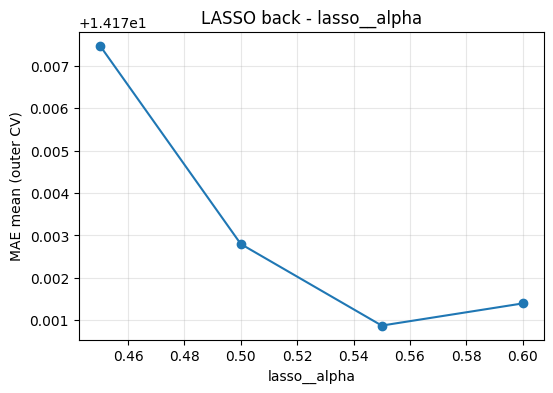

In [33]:
plot_grid_search_results(
    bundle_lasso_back["summary_df"],
    param_name="lasso__alpha",
    model_name="LASSO back"
)
plt.show()

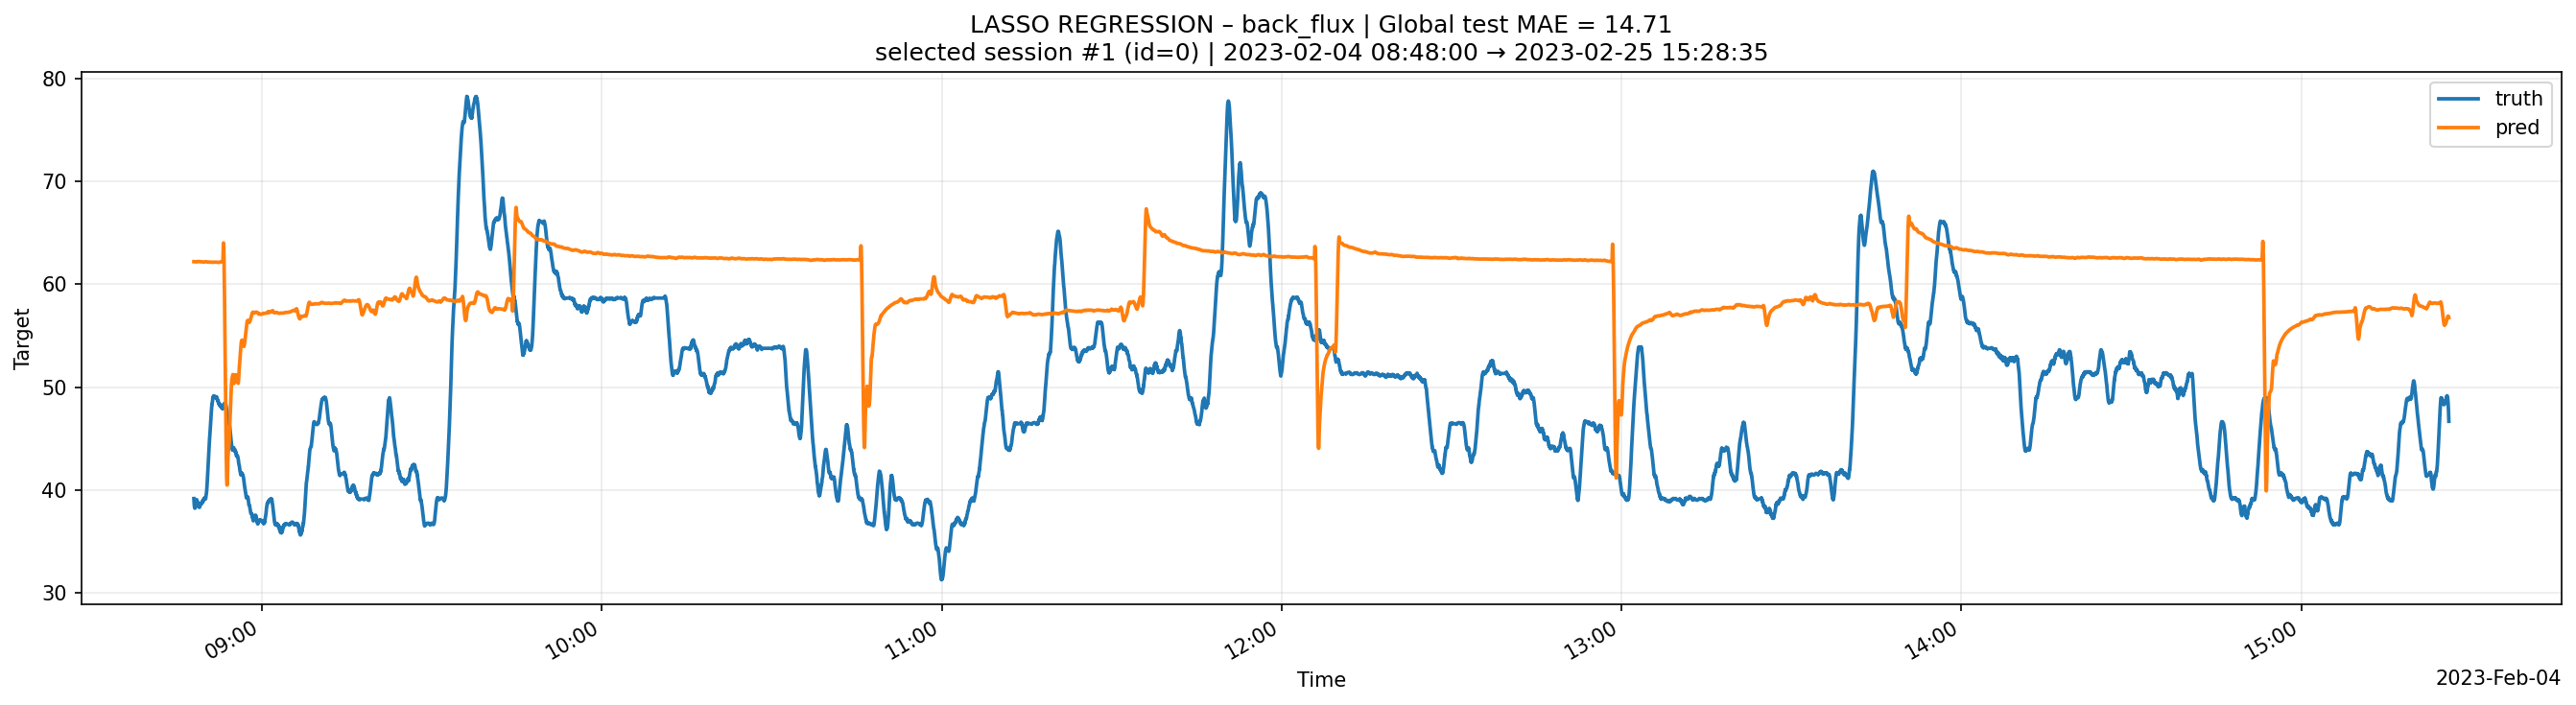

In [34]:
pred_df_back = predict_and_plot(
    model=model_lasso_back,
    X_test=X_test,
    y_test=y_test["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LASSO REGRESSION – back_flux"
)

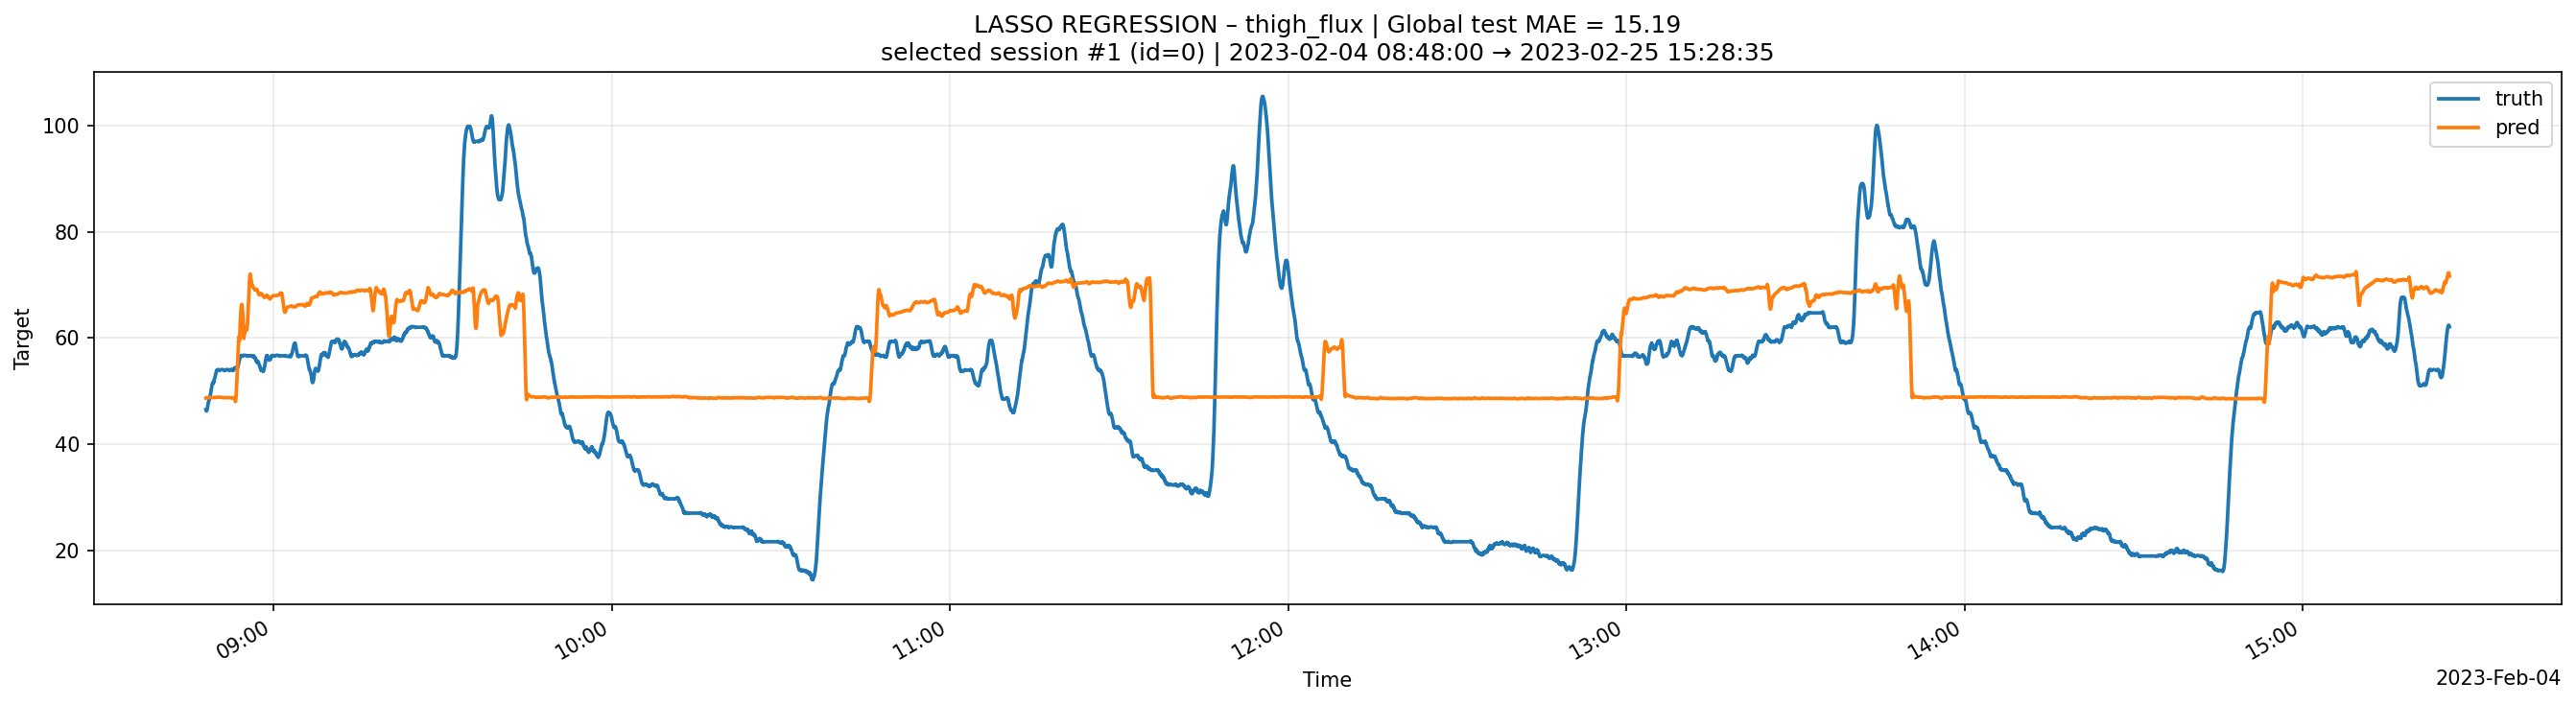

In [35]:
pred_df_thigh = predict_and_plot(
    model=model_lasso_thigh,
    X_test=X_test,
    y_test=y_test["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LASSO REGRESSION – thigh_flux"
)

### 2.C Ridge Regressio: Grid Search and Plots

In [36]:
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

ridge_grid = {
    "ridge__alpha": [10.0, 100.0, 150.0, 200.0, 250.0, 300.0, 1000.0, 5000.0, 10000.0, 20000.0, 50000.0, 100000.0, 500000.0]
}

bundle_ridge_back = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["back_flux"]],
    base_estimator=ridge_pipe,
    param_grid=ridge_grid,
    model_name="ridge",
    model_title="RIDGE_back_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[ridge] #param combinations: 13 | outer folds: 5
  Combo 1/13: {'ridge__alpha': 10.0}
    MAE mean/std over folds: 14.2132 ± 1.9852
  Combo 2/13: {'ridge__alpha': 100.0}
    MAE mean/std over folds: 14.2131 ± 1.9859
  Combo 3/13: {'ridge__alpha': 150.0}
    MAE mean/std over folds: 14.2130 ± 1.9863
  Combo 4/13: {'ridge__alpha': 200.0}
    MAE mean/std over folds: 14.2129 ± 1.9867
  Combo 5/13: {'ridge__alpha': 250.0}
    MAE mean/std over folds: 14.2129 ± 1.9871
  Combo 6/13: {'ridge__alpha': 300.0}
    MAE mean/std over folds: 14.2128 ± 1.9875
  Combo 7/13: {'ridge__alpha': 1000.0}
    MAE mean/std over folds: 14.2120 ± 1.9926
  Combo 8/13: {'ridge__alpha': 5000.0}
    MAE mean/std over folds: 14.2103 ± 2.0183
  Combo 9/13: {'ridge__alpha': 10000.0}
    MAE mean/std over folds: 14.2112 ± 2.0427
  Combo 10/13: {'ridge__alpha': 20000.0}
    MAE mean/std over folds: 14.2146 ± 2.0766
  Combo 11/13: {'ridge__alpha': 50000.0}
    MAE mean/std over folds: 14.2244 ± 2.1215
  Combo 12/13: {'r

In [37]:
bundle_ridge_thigh = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train[["thigh_flux"]],
    base_estimator=ridge_pipe,
    param_grid=ridge_grid,
    model_name="ridge",
    model_title="RIDGE_thigh_flux",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[ridge] #param combinations: 13 | outer folds: 5
  Combo 1/13: {'ridge__alpha': 10.0}
    MAE mean/std over folds: 15.7949 ± 1.9085
  Combo 2/13: {'ridge__alpha': 100.0}
    MAE mean/std over folds: 15.7937 ± 1.9089
  Combo 3/13: {'ridge__alpha': 150.0}
    MAE mean/std over folds: 15.7930 ± 1.9091
  Combo 4/13: {'ridge__alpha': 200.0}
    MAE mean/std over folds: 15.7924 ± 1.9093
  Combo 5/13: {'ridge__alpha': 250.0}
    MAE mean/std over folds: 15.7917 ± 1.9095
  Combo 6/13: {'ridge__alpha': 300.0}
    MAE mean/std over folds: 15.7911 ± 1.9097
  Combo 7/13: {'ridge__alpha': 1000.0}
    MAE mean/std over folds: 15.7823 ± 1.9126
  Combo 8/13: {'ridge__alpha': 5000.0}
    MAE mean/std over folds: 15.7392 ± 1.9293
  Combo 9/13: {'ridge__alpha': 10000.0}
    MAE mean/std over folds: 15.6995 ± 1.9493
  Combo 10/13: {'ridge__alpha': 20000.0}
    MAE mean/std over folds: 15.6500 ± 1.9853
  Combo 11/13: {'ridge__alpha': 50000.0}
    MAE mean/std over folds: 15.6094 ± 2.0612
  Combo 12/13: {'r

In [38]:
# bundle_ridge_back = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RIDGE_back_flux.joblib')
# bundle_ridge_thigh = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RIDGE_thigh_flux.joblib')

In [39]:
model_ridge_back  = bundle_ridge_back["model"]
model_ridge_thigh = bundle_ridge_thigh["model"]

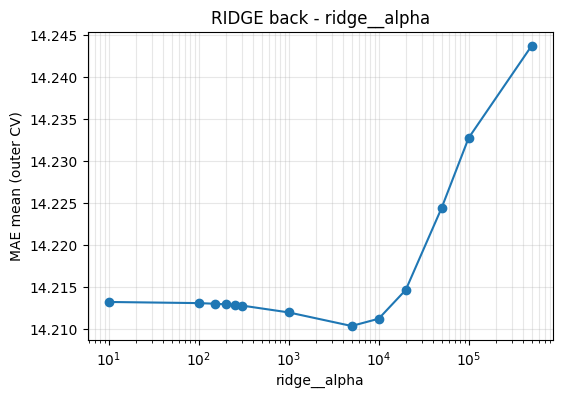

In [40]:
plot_grid_search_results(
    bundle_ridge_back["summary_df"],
    param_name="ridge__alpha",
    model_name="RIDGE back"
)
plt.show()

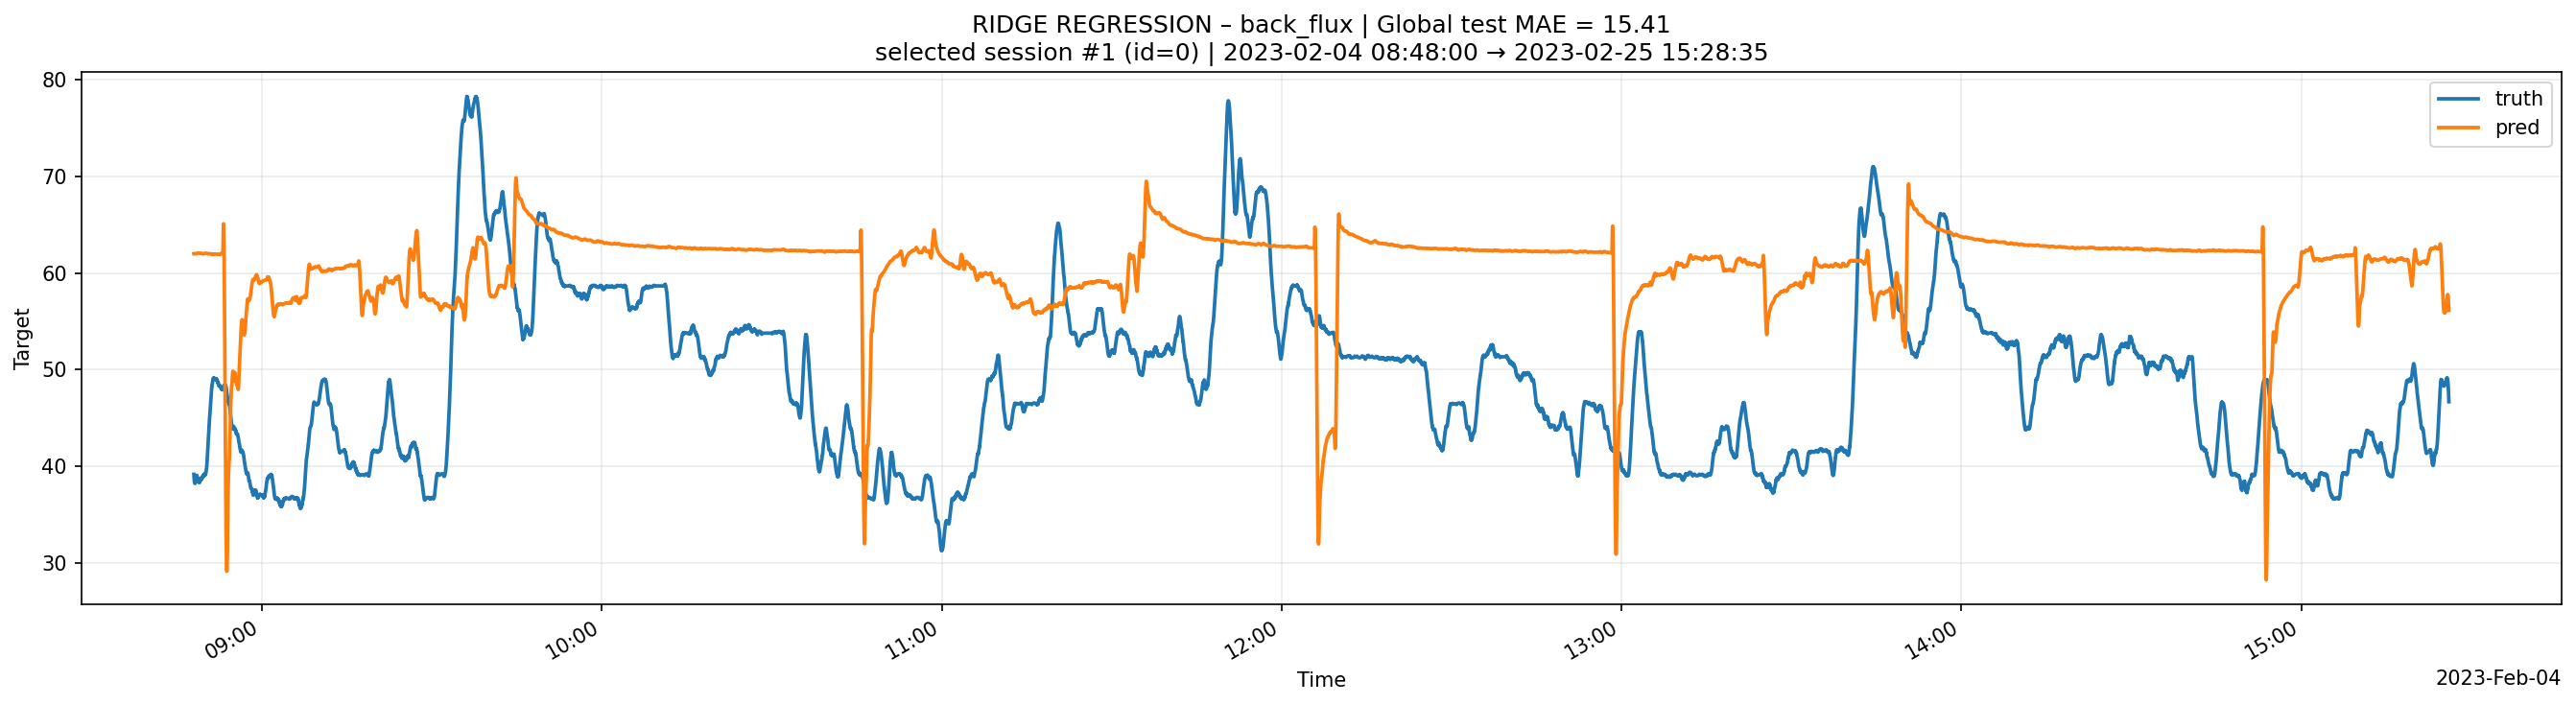

In [41]:
pred_df_back = predict_and_plot(
    model=model_ridge_back,
    X_test=X_test,
    y_test=y_test["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RIDGE REGRESSION – back_flux"
)

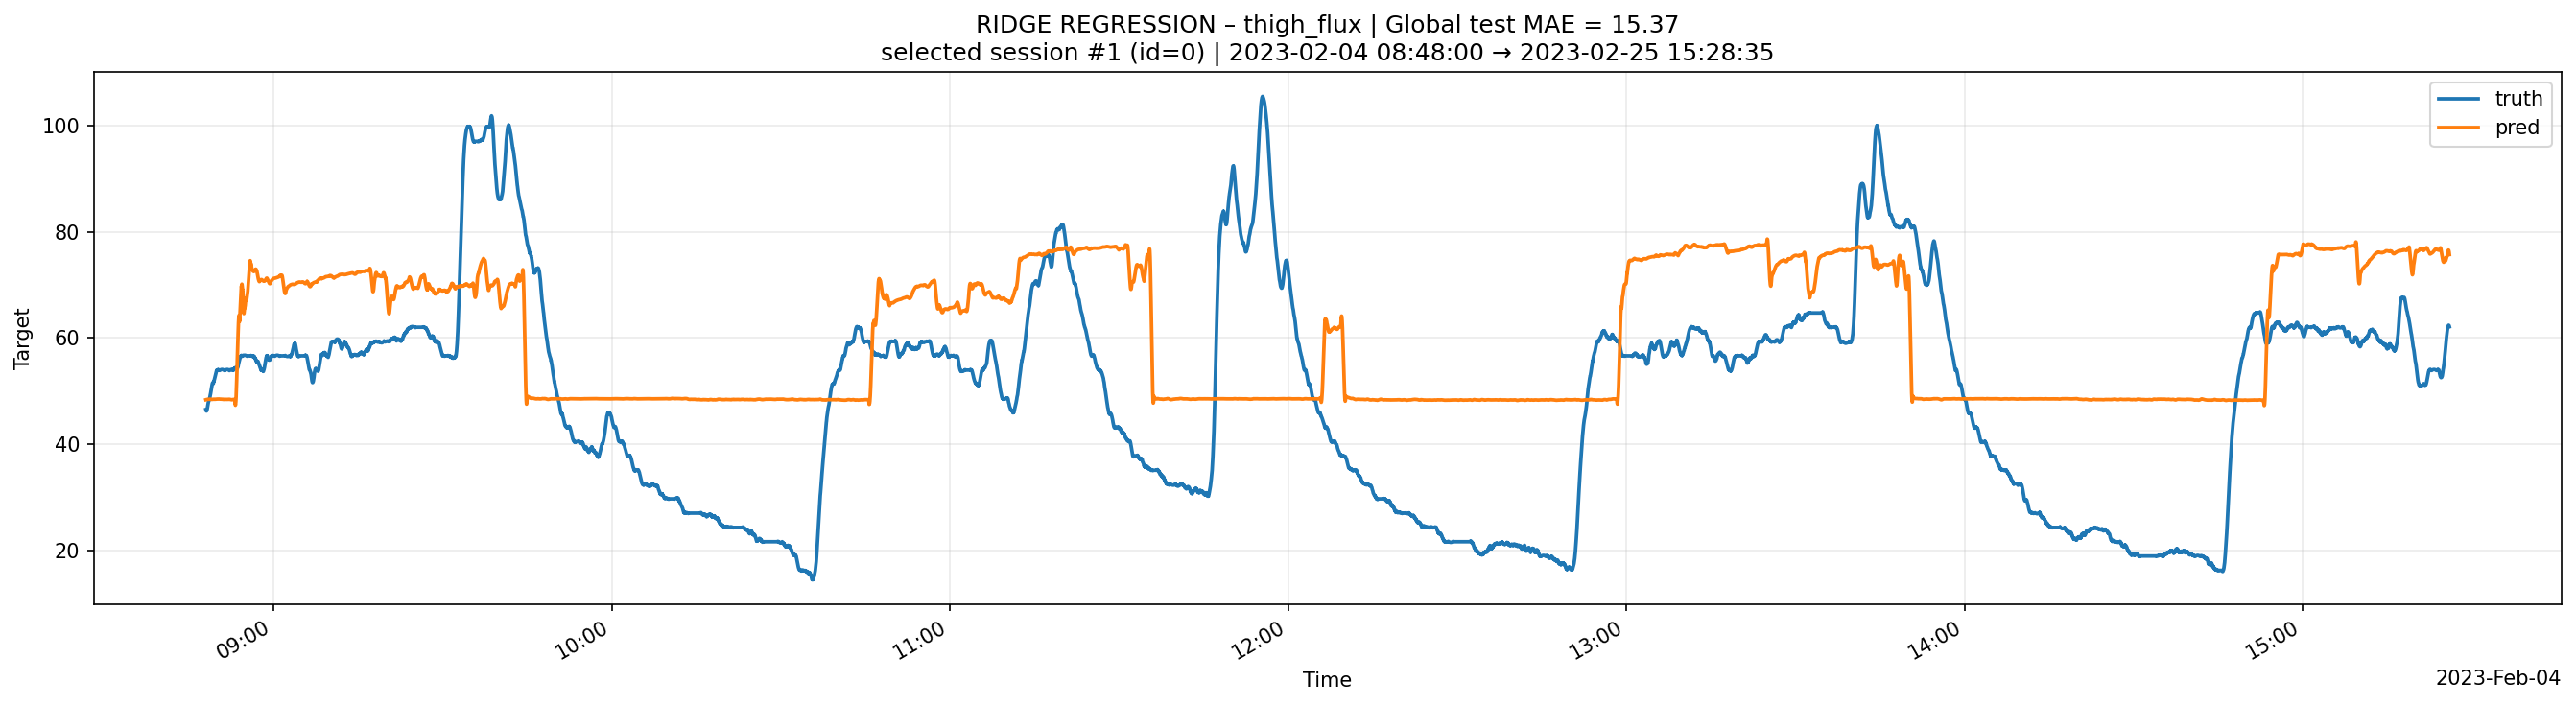

In [42]:
pred_df_thigh = predict_and_plot(
    model=model_ridge_thigh,
    X_test=X_test,
    y_test=y_test["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RIDGE REGRESSION – thigh_flux"
)

### 2.D Random Forest: Grid Search and Plots

In [43]:
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [8, 12],
    "min_samples_split": [5, 10],
}

# bundle_rf_back = cv_select_and_refit_on_full_train(
    # X_train=X_train,
    # y_train=y_train[["back_flux"]],
    # base_estimator=rf,
    # param_grid=rf_grid,
    # model_name="random_forest",
    # model_title="RF_back_flux",
    # participant_col="participant_id",
    # time_col="Time",
    # n_outer_splits=5,
    # return_oof=True,
    # bundle_dir=RUNS_DIR
# )

In [44]:
# bundle_rf_thigh = cv_select_and_refit_on_full_train(
    # X_train=X_train,
    # y_train=y_train[["thigh_flux"]],
    # base_estimator=rf,
    # param_grid=rf_grid,
    # model_name="random_forest",
    # model_title="RF_thigh_flux",
    # participant_col="participant_id",
    # time_col="Time",
    # n_outer_splits=5,
    # return_oof=True,
    # bundle_dir=RUNS_DIR
# )

In [45]:
drive.mount('/content/drive')
!ls /content/drive/MyDrive/ICE-human-heatflux-project/
BASE_PATH = "/content/drive/MyDrive/ICE-human-heatflux-project"
RUNS_DIR = "/content/drive/MyDrive/ICE-human-heatflux-project/runs"
sys.path.append(BASE_PATH)

from Baseline_training_utils_2 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Baseline_training_utils_2.py	       runs
 lstm_utils.py			       runs_2
 lstm_v1.pth			       Test_final.csv
 __pycache__			       Test_without_FE.csv
'Resultats_LSTM_without_FE (1).gdoc'   Train_final.csv
 Resultats_LSTM_without_FE.gdoc        Train_without_FE.csv


In [48]:
bundle_rf_back = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RF_back_flux.joblib')
bundle_rf_thigh = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RF_thigh_flux.joblib')

In [49]:
model_rf_back = bundle_rf_back["model"]
model_rf_thigh = bundle_rf_thigh["model"]

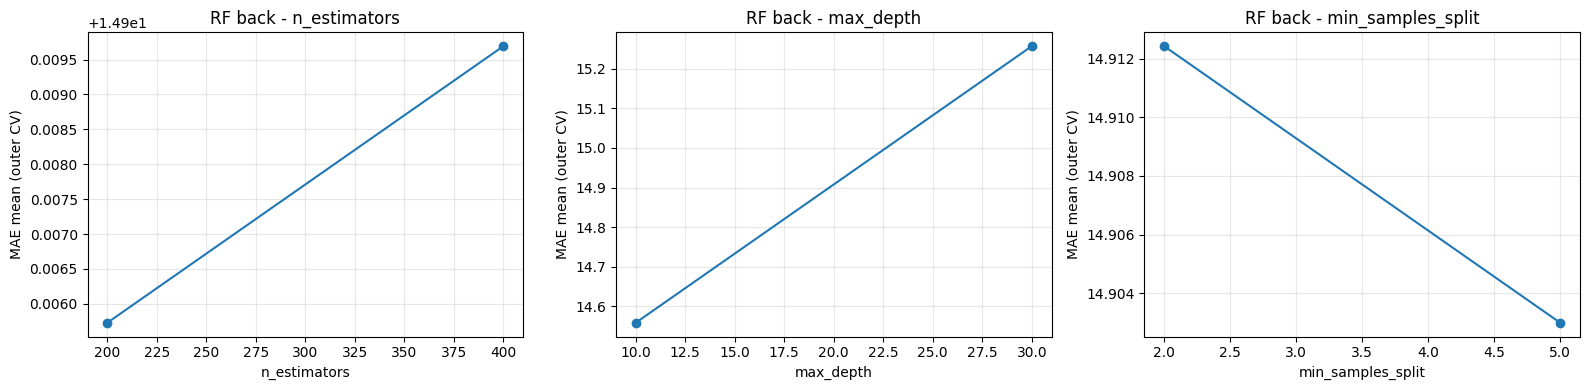

In [50]:
plot_rf_grid_search(bundle_rf_back["summary_df"], model_name="RF back")

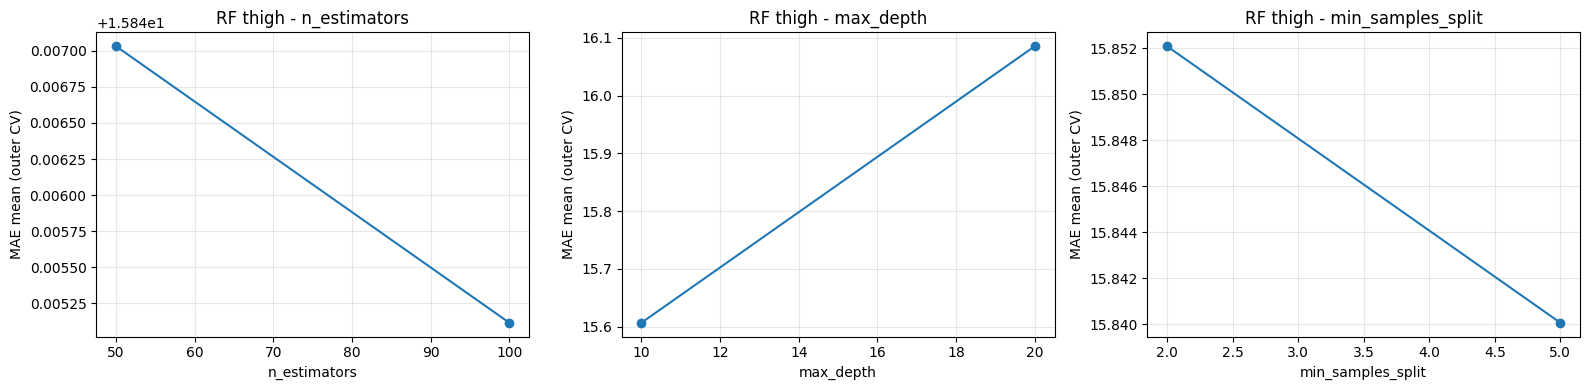

In [51]:
plot_rf_grid_search(bundle_rf_thigh["summary_df"], model_name="RF thigh")

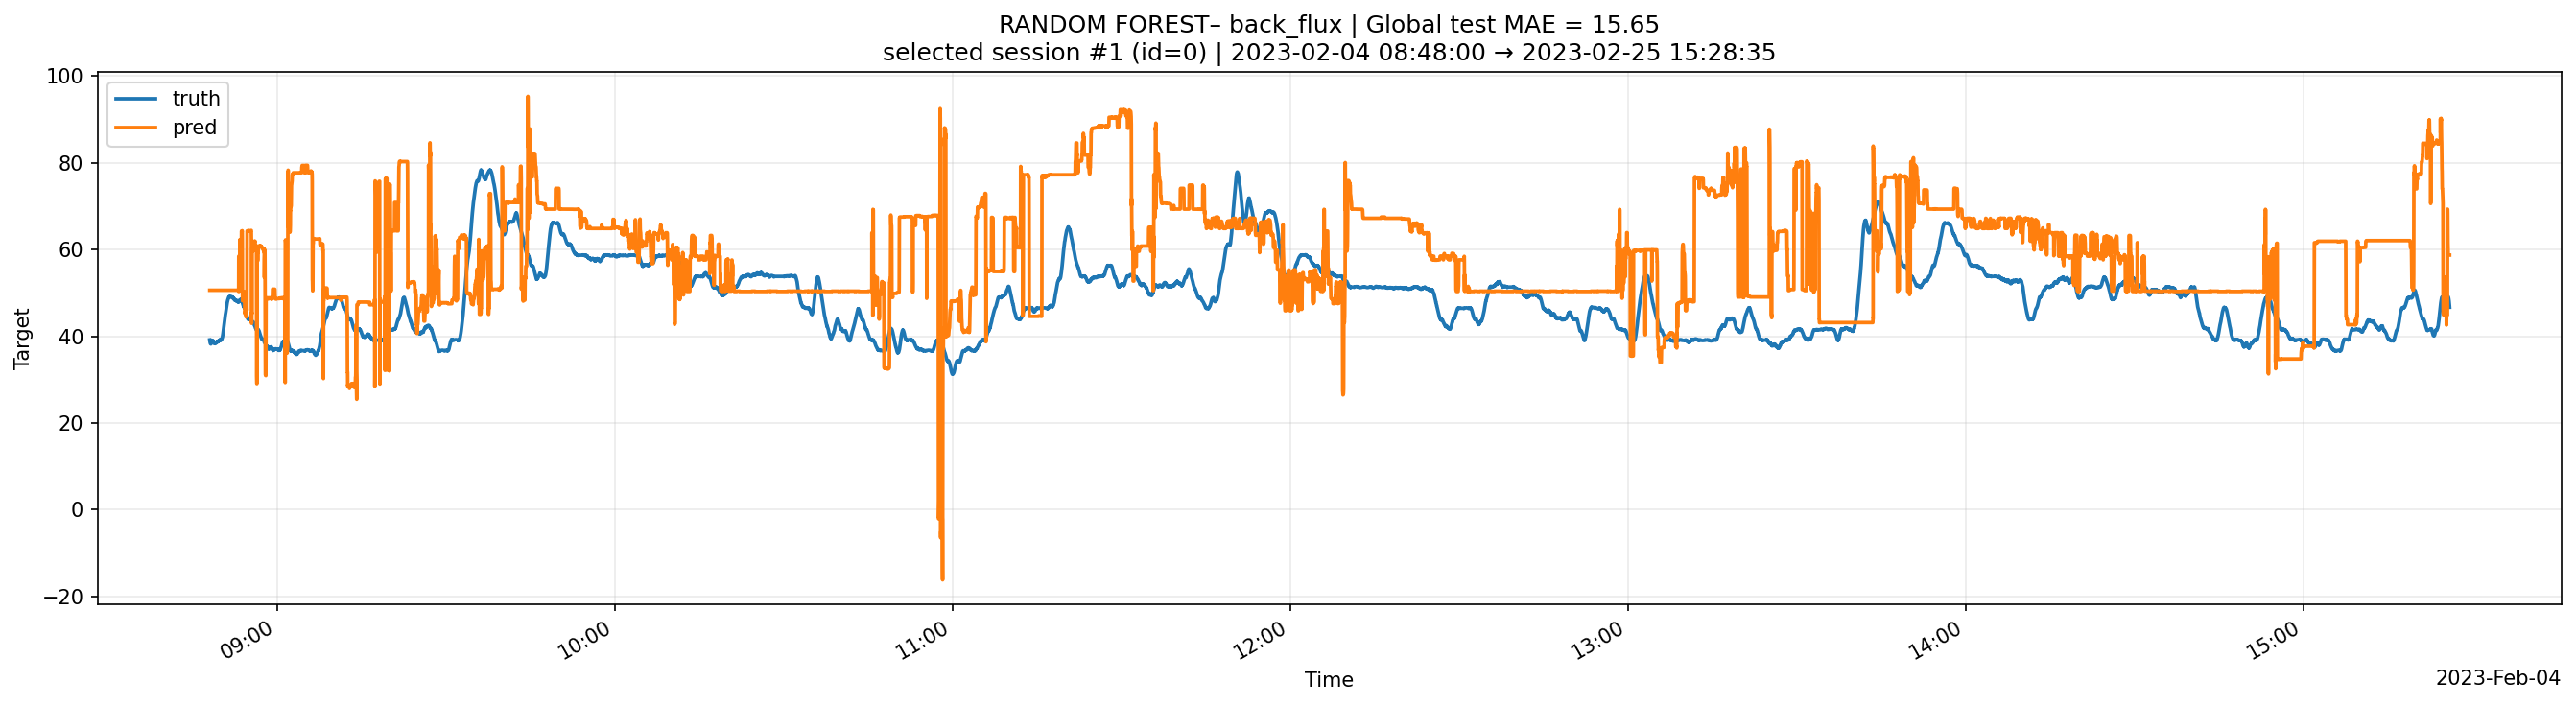

In [52]:
pred_df_thigh = predict_and_plot(
    model=model_rf_back,
    X_test=X_test,
    y_test=y_test["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RANDOM FOREST– back_flux"
)

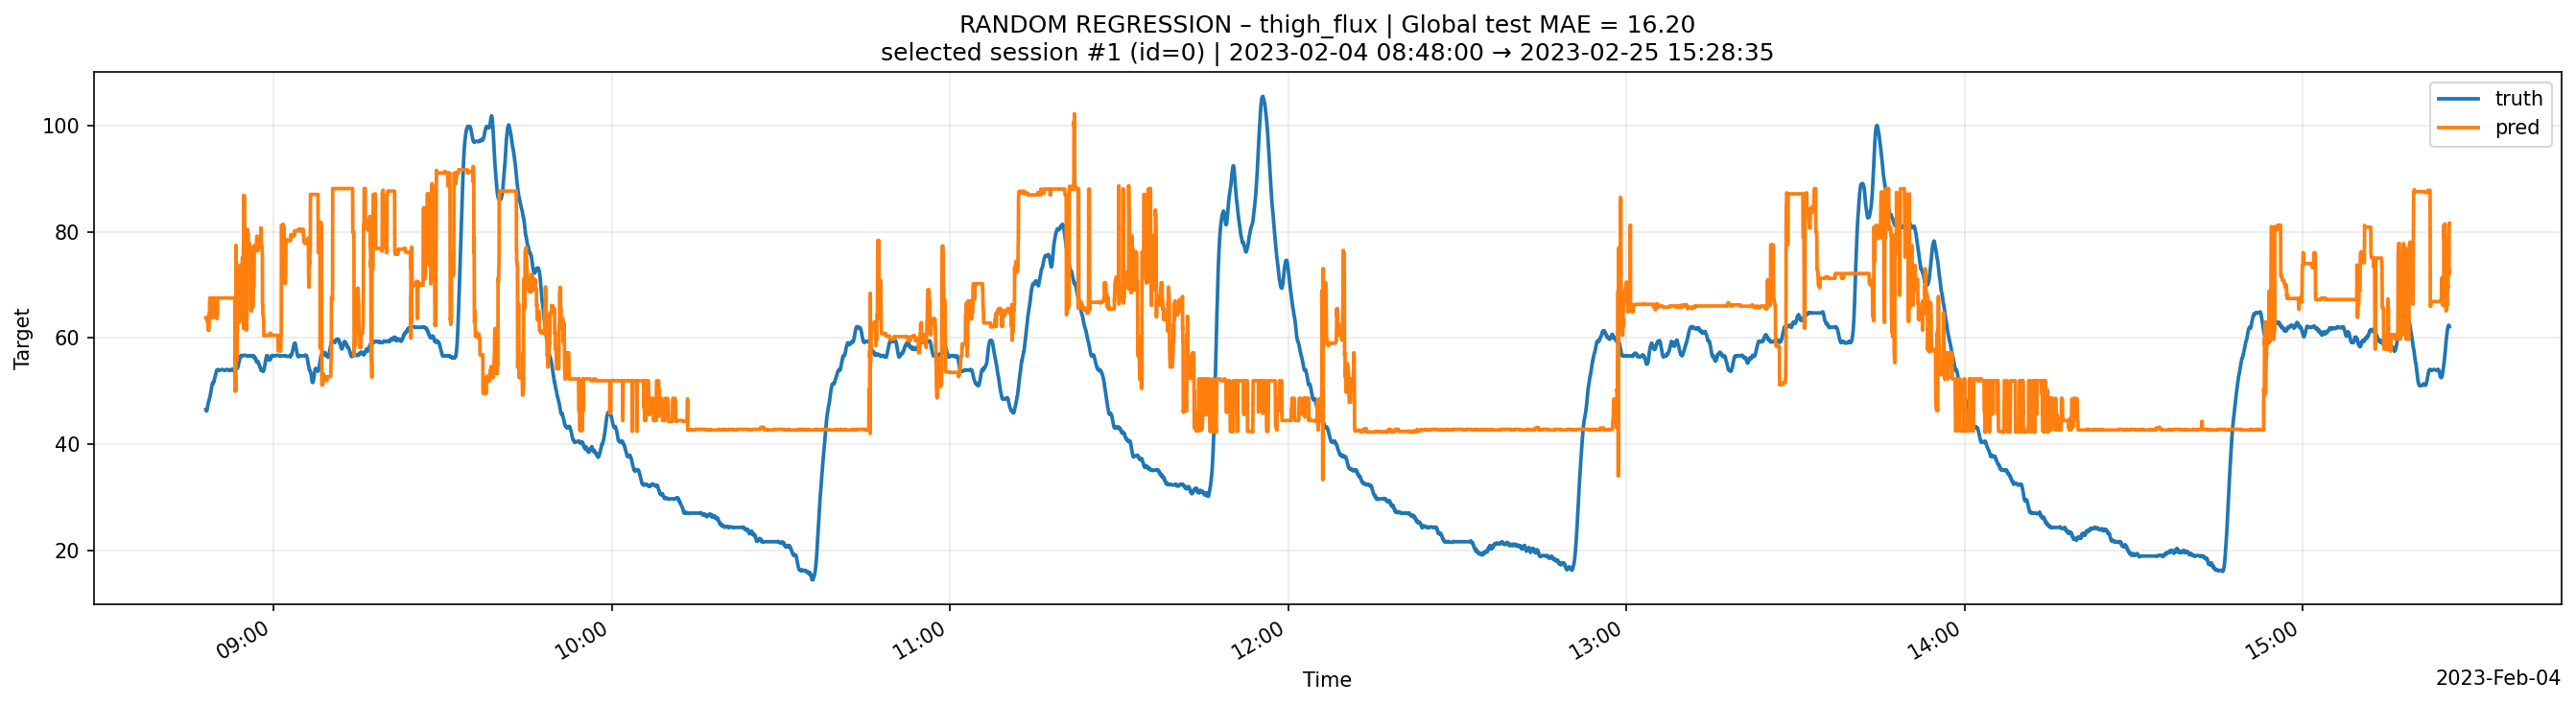

In [53]:
pred_df_thigh = predict_and_plot(
    model=model_rf_thigh,
    X_test=X_test,
    y_test=y_test["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RANDOM REGRESSION – thigh_flux"
)

## Task 3: Baseline single-output models with historical features

## 3.A Linear Regression: Plots

In [54]:
linear_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

bundle_linear_back_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["back_flux"]],
    base_estimator=linear_pipe,
    param_grid={},
    model_name="linear_regression",
    model_title="LR_back_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[linear_regression] #param combinations: 1 | outer folds: 5
  Combo 1/1: {}
    MAE mean/std over folds: 14.2322 ± 1.9054

[linear_regression] BEST params = {}
[linear_regression] BEST MAE = 14.2322

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_back_flux_with_HF.joblib


In [55]:
bundle_linear_thigh_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["thigh_flux"]],
    base_estimator=linear_pipe,
    param_grid={},
    model_name="linear_regression",
    model_title="LR_thigh_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[linear_regression] #param combinations: 1 | outer folds: 5
  Combo 1/1: {}
    MAE mean/std over folds: 15.7480 ± 1.8495

[linear_regression] BEST params = {}
[linear_regression] BEST MAE = 15.7480

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_thigh_flux_with_HF.joblib


In [ ]:
# bundle_linear_back_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_thigh_flux_with_HF.joblib')
# bundle_linear_thigh_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LR_back_flux_with_HF.joblib')

In [56]:
model_linear_back_HF = bundle_linear_back_HF["model"]
model_linear_thigh_HF = bundle_linear_thigh_HF["model"]

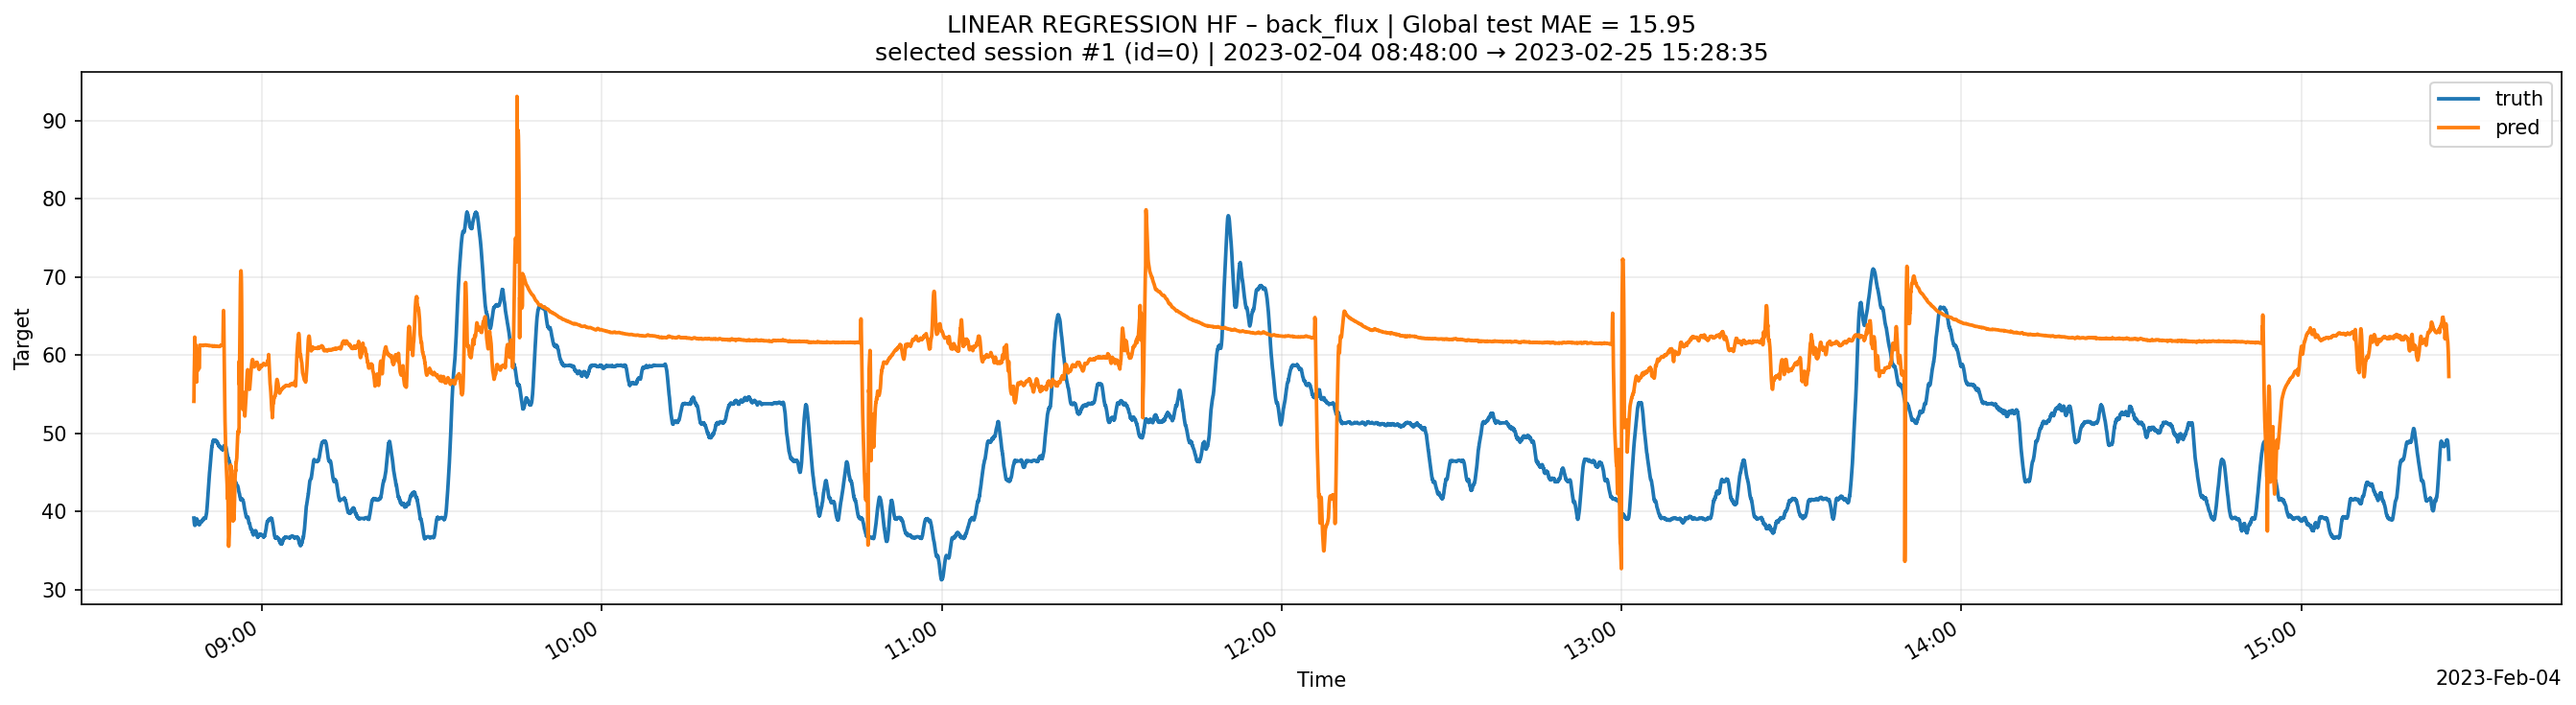

In [57]:
pred_df_back = predict_and_plot(
    model=model_linear_back_HF,
    X_test=X_test_HF,
    y_test=y_test_HF["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LINEAR REGRESSION HF – back_flux"
)

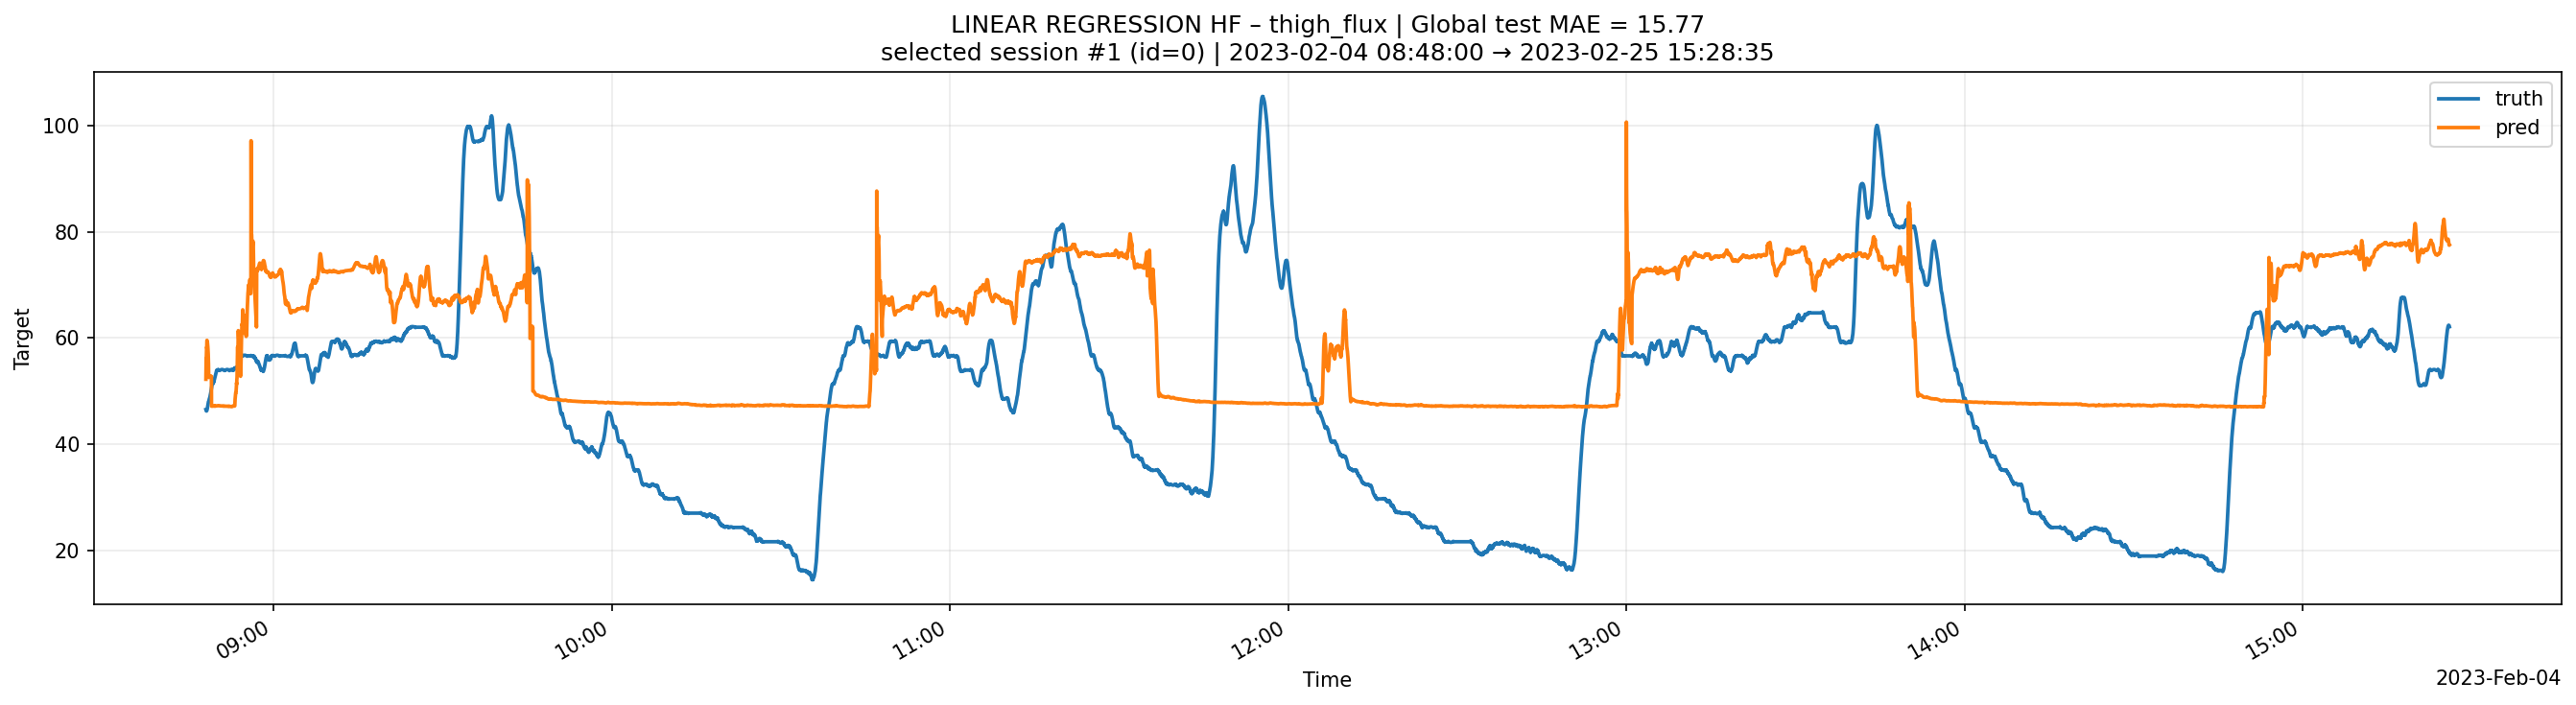

In [58]:
pred_df_thigh = predict_and_plot(
    model=model_linear_thigh_HF,
    X_test=X_test_HF,
    y_test=y_test_HF["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LINEAR REGRESSION HF – thigh_flux"
)

## 3.B Lasso regression: Grid search and plots

In [59]:
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=10_000))
])

In [60]:
lasso_grid = {
    "lasso__alpha": [0.45, 0.5, 0.55, 0.6]
}

In [61]:
bundle_lasso_back_with_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["back_flux"]],
    base_estimator=lasso_pipe,
    param_grid=lasso_grid,
    model_name="lasso",
    model_title="LASSO_back_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[lasso] #param combinations: 4 | outer folds: 5
  Combo 1/4: {'lasso__alpha': 0.45}
    MAE mean/std over folds: 14.1325 ± 2.2033
  Combo 2/4: {'lasso__alpha': 0.5}
    MAE mean/std over folds: 14.1274 ± 2.1997
  Combo 3/4: {'lasso__alpha': 0.55}
    MAE mean/std over folds: 14.1237 ± 2.1984
  Combo 4/4: {'lasso__alpha': 0.6}
    MAE mean/std over folds: 14.1264 ± 2.1990

[lasso] BEST params = {'lasso__alpha': 0.55}
[lasso] BEST MAE = 14.1237

[SAVE] bundle -> /content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_back_flux_with_HF.joblib


In [ ]:
bundle_lasso_thigh_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["thigh_flux"]],
    base_estimator=lasso_pipe,
    param_grid=lasso_grid,
    model_name="lasso",
    model_title="LASSO_thigh_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

[lasso] #param combinations: 4 | outer folds: 5
  Combo 1/4: {'lasso__alpha': 0.45}
    MAE mean/std over folds: 15.3575 ± 1.8006
  Combo 2/4: {'lasso__alpha': 0.5}


In [ ]:
# bundle_lasso_back_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_back_flux_with_HF.joblib')
# bundle_lasso_thigh_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/LASSO_thigh_flux_with_HF.joblib')

In [ ]:
model_lasso_back = bundle_lasso_back_HF["model"]
model_lasso_thigh = bundle_lasso_thigh_HF["model"]

In [ ]:
plot_grid_search_results(
    bundle_lasso_back["summary_df"],
    param_name="lasso__alpha",
    model_name="LASSO HF back"
)
plt.show()

In [ ]:
pred_df_back = predict_and_plot(
    model=model_lasso_back,
    X_test=X_test_HF,
    y_test=y_test_HF["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LASSO REGRESSION HF – back_flux"
)

In [ ]:
pred_df_thigh = predict_and_plot(
    model=model_lasso_thigh,
    X_test=X_test_HF,
    y_test=y_test_HF["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="LASSO REGRESSION HF – thigh_flux"
)

## 3.C Ridge Regression: Grid search and plots

In [ ]:
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

In [ ]:
ridge_grid = {
    "ridge__alpha": [10.0, 100.0, 150.0, 200.0, 250.0, 300.0, 1000.0, 5000.0, 10000.0, 20000.0, 50000.0, 100000.0, 500000.0]
}

In [ ]:
bundle_ridge_back_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["back_flux"]],
    base_estimator=ridge_pipe,
    param_grid=ridge_grid,
    model_name="ridge",
    model_title="RIDGE_back_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

In [ ]:
bundle_ridge_thigh_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["thigh_flux"]],
    base_estimator=ridge_pipe,
    param_grid=ridge_grid,
    model_name="ridge",
    model_title="RIDGE_thigh_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

In [ ]:
# bundle_ridge_back_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RIDGE_back_flux_with_HF.joblib')
# bundle_ridge_thigh_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RIDGE_thigh_flux_with_HF.joblib')

In [ ]:
model_ridge_back_HF  = bundle_ridge_back_HF["model"]
model_ridge_thigh_HF = bundle_ridge_thigh_HF["model"]

In [ ]:
plot_grid_search_results(
    bundle_ridge_back["summary_df"],
    param_name="ridge__alpha",
    model_name="RIDGE HF back"
)
plt.show()

In [ ]:
pred_df_back = predict_and_plot(
    model=model_ridge_back,
    X_test=X_test_HF,
    y_test=y_test_HF["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RIDGE REGRESSION HF – back_flux"
)

In [ ]:
pred_df_thigh = predict_and_plot(
    model=model_ridge_thigh,
    X_test=X_test_HF,
    y_test=y_test_HF["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RIDGE REGRESSION HF – thigh_flux"
)

## 3.D Random Forest: Grid Search and plots

In [ ]:
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [8, 12],
    "min_samples_split": [5, 10],
}

bundle_rf_back_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["back_flux"]],
    base_estimator=rf,
    param_grid=rf_grid,
    model_name="random_forest",
    model_title="RF_back_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

In [ ]:
bundle_rf_thigh_HF = cv_select_and_refit_on_full_train(
    X_train=X_train_HF,
    y_train=y_train_HF[["thigh_flux"]],
    base_estimator=rf,
    param_grid=rf_grid,
    model_name="random_forest",
    model_title="RF_thigh_flux_with_HF",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    return_oof=True,
    bundle_dir=RUNS_DIR
)

In [ ]:
# bundle_rf_back_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RF_back_flux_with_HF.joblib')
# bundle_rf_thigh_HF = joblib.load('/content/drive/MyDrive/ICE-human-heatflux-project/runs/RF_thigh_flux_with_HF.joblib')

In [ ]:
model_rf_back = bundle_rf_back_HF["model"]
model_rf_thigh = bundle_rf_thigh_HF["model"]

In [ ]:
plot_rf_grid_search(bundle_rf_back["summary_df"], model_name="RF back")

In [ ]:
plot_rf_grid_search(bundle_rf_thigh["summary_df"], model_name="RF thigh")
pred_df_thigh = predict_and_plot(
    model=model_rf_back_HF,
    X_test=X_test,
    y_test=y_test["back_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RANDOM FOREST HF – back_flux"
)

In [ ]:
plot_rf_grid_search(bundle_rf_thigh["summary_df"], model_name="RF thigh")
pred_df_thigh = predict_and_plot(
    model=model_rf_thigh_HF,
    X_test=X_test,
    y_test=y_test["thigh_flux"],
    participant_col="participant_id",
    time_col="Time",
    participant_id="F7",
    mode="selected",
    gap_minutes=60,
    compress_gaps=True,
    title="RANDOM FOREST HF – thigh_flux"
)